In [1]:
#  Required imports
print("Importing standard library")
import os, time, sys

print("Importing python data libraries")
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

print("Importing custom backends")
from   backends.stats import special_whiten_dataset, special_unwhiten_dataset
from   backends.utils import joint_shuffle, make_sure_dir_exists_for_filename
from   backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model3
from   backends.SamplingSimulator      import SamplingSimulator

print("Importing keras objects")
from keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape
from keras.models      import Model, Sequential
from keras.optimizers  import Adam, SGD, RMSprop
from keras.constraints import Constraint, MaxNorm
from keras.callbacks   import EarlyStopping

print("Importing keras backend")
import keras.backend as K

Importing standard library
Importing python data libraries
Importing custom backends
Importing keras objects


Using TensorFlow backend.


Importing keras backend


In [ ]:
#  Program constants

mu_scan_points = np.linspace(-2, 3, 11)

n_gen_points_per_c_per_ds        = 50000
use_Adam_optimiser               = False
do_wgan_gp                       = False
wgan_weight_clipping             = 0.01
do_use_critic_tanh               = False
GRADIENT_PENALTY_WEIGHT          = 1

do_whiten_data = True
white_linear_fraction = 0.5

plot_tag = None

axis_lims = [(50, 250), (50, 500), (-1*np.pi, np.pi)]
if do_whiten_data : axis_lims = [(-5., 5.), (-5., 5.), (-5., 5.)]

In [3]:
#  Set up "true" model
model = Simulator_Model3

#  Generate several scan points for "true" model
xsections, datasets, weights = {}, {}, {}
for mu in mu_scan_points :
    model.set_param_value("c", mu)
    xsec, dataset = model.generate(n_gen_points_per_c_per_ds)
    xsections [mu] = xsec
    datasets  [mu] = dataset
    weights   [mu] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
    
#  Make sure one of the datasets was the SM
model.set_param_value("c", 0)
if 0 not in xsections :
    xsections [0], datasets [0] = model.generate(n_gen_points_per_c_per_ds)
    mu_scan_points = np.sort(np.concatenate([mu_scan_points, [0]]))
    weights [0] = np.full(shape=(len(dataset),), fill_value=1./n_gen_points_per_c_per_ds)
xsec_SM, dataset_SM, weights_SM = xsections[0], datasets[0], weights[0]

#  Whiten the data using the "special" hard-boundary-respecting method
if do_whiten_data :
    white_dataset_SM, whitening_funcs, whitening_params = special_whiten_dataset (dataset_SM,
                                                                                  [50, 250, 201, white_linear_fraction],
                                                                                  [50, 500, 301, white_linear_fraction],
                                                                                  [-1.*np.pi, np.pi, 101, white_linear_fraction],
                                                                                  rotate=True)
else :
    white_dataset_SM, whitening_funcs, whitening_params = dataset_SM, None, None

def whiten_data (dataset) :
    if do_whiten_data == False : return dataset
    white_datasets = {}
    for mu in dataset :
        white_datasets [mu], _, _ = special_whiten_dataset (dataset[mu], 
                                                            whitening_funcs =whitening_funcs, 
                                                            whitening_params=whitening_params,
                                                            rotate=True)
    return white_datasets

def unwhiten_data (dataset) : 
    if do_whiten_data == False : return dataset 
    unwhite_datasets = {}
    for mu in dataset :
        unwhite_datasets [mu] = special_unwhiten_dataset (dataset[mu], 
                                                          whitening_funcs =whitening_funcs, 
                                                          whitening_params=whitening_params)
    return unwhite_datasets
        
white_datasets   = whiten_data  (datasets      )
unwhite_datasets = unwhiten_data(white_datasets)
num_datasets = len(white_datasets)
print(f"Datasets generated for scan points: {', '.join([f'{mu:.3f}' for mu in mu_scan_points])}")

Datasets generated for scan points: -2.000, -1.500, -1.000, -0.500, 0.000, 0.500, 1.000, 1.500, 2.000, 2.500, 3.000


In [4]:
def plot_dataset (mu_scan_points, xsections, datasets, weights=None, ref=None) :
    num_datasets = len(mu_scan_points)
           
    if type(weights) == type(None) :
        tmp_weights = {mu:np.full(fill_value=1./len(datasets[mu]), shape=(len(datasets[mu]),)) for mu in mu_scan_points}
    elif type(weights) == np.ndarray :
        tmp_weights = {mu:weights/np.sum(weights) for mu in mu_scan_points}
    elif type(weights) == dict : 
        tmp_weights = {mu:tmp_weights/np.sum(tmp_weights) for mu, tmp_weights in weights.items()}
    else :
        raise TypeError(f"Don't know what to do with weights of type {type(weights)}")
    
    plot_reference = False
    if type(ref) != type(None) :
        plot_reference = True
        xsections_ref, datasets_ref, weights_ref = ref
        
        if type(datasets_ref) == np.ndarray :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        elif type(datasets_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            raise TypeError(f"Don't know what to do with reference dataset of type {type(datasets_ref)}")
            
        if type(weights_ref) == type(None) :
            tmp_weights_ref = {mu:np.full(fill_value=1/len(tmp_datasets_ref[mu]), shape=(len(tmp_datasets_ref[mu]),)) for mu in mu_scan_points}
        elif type(weights_ref) == np.ndarray :
            tmp_weights_ref = {mu:weights_ref/np.sum(weights_ref) for mu in mu_scan_points}
        elif type(weights_ref) == dict : 
            tmp_weights_ref = {mu:tmp_weights_ref/np.sum(tmp_weights_ref) for mu, tmp_weights_ref in weights_ref.items()}
        else :
            raise TypeError(f"Don't know what to do with reference weights of type {type(weights_ref)}")
            
        if type(xsections_ref) == dict : 
            tmp_datasets_ref = datasets_ref
        else :
            tmp_datasets_ref = {mu:datasets_ref for mu in mu_scan_points}
        
        if type(xsections_ref) == type(None) :
            raise RuntimeError(f"Reference datasets must be provided reference cross sections too")
        if type(datasets_ref) == dict : 
            tmp_xsections_ref = xsections_ref
        else :
            tmp_xsections_ref = {mu:xsections_ref for mu in mu_scan_points}

    num_plot_rows = 6
    if plot_reference : num_plot_rows = 9
    
    fig = plt.figure(figsize=(4*num_datasets, 4*num_plot_rows))
    plot_row_idx = 0
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,0], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-", linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,0], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        ax1.set_title(f"$c = {mu:.3f}$", fontsize=30)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,1], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,1], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets  [mu]
        xsec    = xsections [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist(dataset[:,2], alpha=0.5, weights=xsec*weight, fill=False, edgecolor="k", linestyle="-" , linewidth=3)
        if plot_reference :
            dataset_ref = tmp_datasets_ref [mu]
            xsec_ref    = tmp_xsections_ref [mu]
            weight_ref  = tmp_weights_ref [mu]
            ax1.hist(dataset_ref[:,2], alpha=0.5, weights=xsec_ref*weight_ref, fill=True, color="r", linestyle="-", linewidth=3)
        if ax_idx > 0 : continue
        ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $B$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,1], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $B$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$A$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,0], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$A$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")

    plot_row_idx = plot_row_idx + 1
    for ax_idx, mu in enumerate(mu_scan_points) :
        dataset = datasets [mu]
        weight  = tmp_weights [mu]
        ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
        ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
        if ax_idx == 0 : 
            ax1.set_ylabel("$B$ \n / \n $C$", fontsize=30, rotation=0, labelpad=40)
    
    if plot_reference :
        plot_row_idx = plot_row_idx + 1
        for ax_idx, mu in enumerate(mu_scan_points) :
            dataset = tmp_datasets_ref [mu]
            weight  = tmp_weights_ref [mu]
            ax1 = fig.add_subplot(num_plot_rows, num_datasets, plot_row_idx*num_datasets + ax_idx + 1)
            ax1.hist2d(dataset[:,1], dataset[:,2], weights=weight)
            if ax_idx == 0 : 
                ax1.set_ylabel("$B$ \n / \n $C$ \n ref", fontsize=30, rotation=0, labelpad=40, va="center")
                
    plt.show()


Plotting datasets


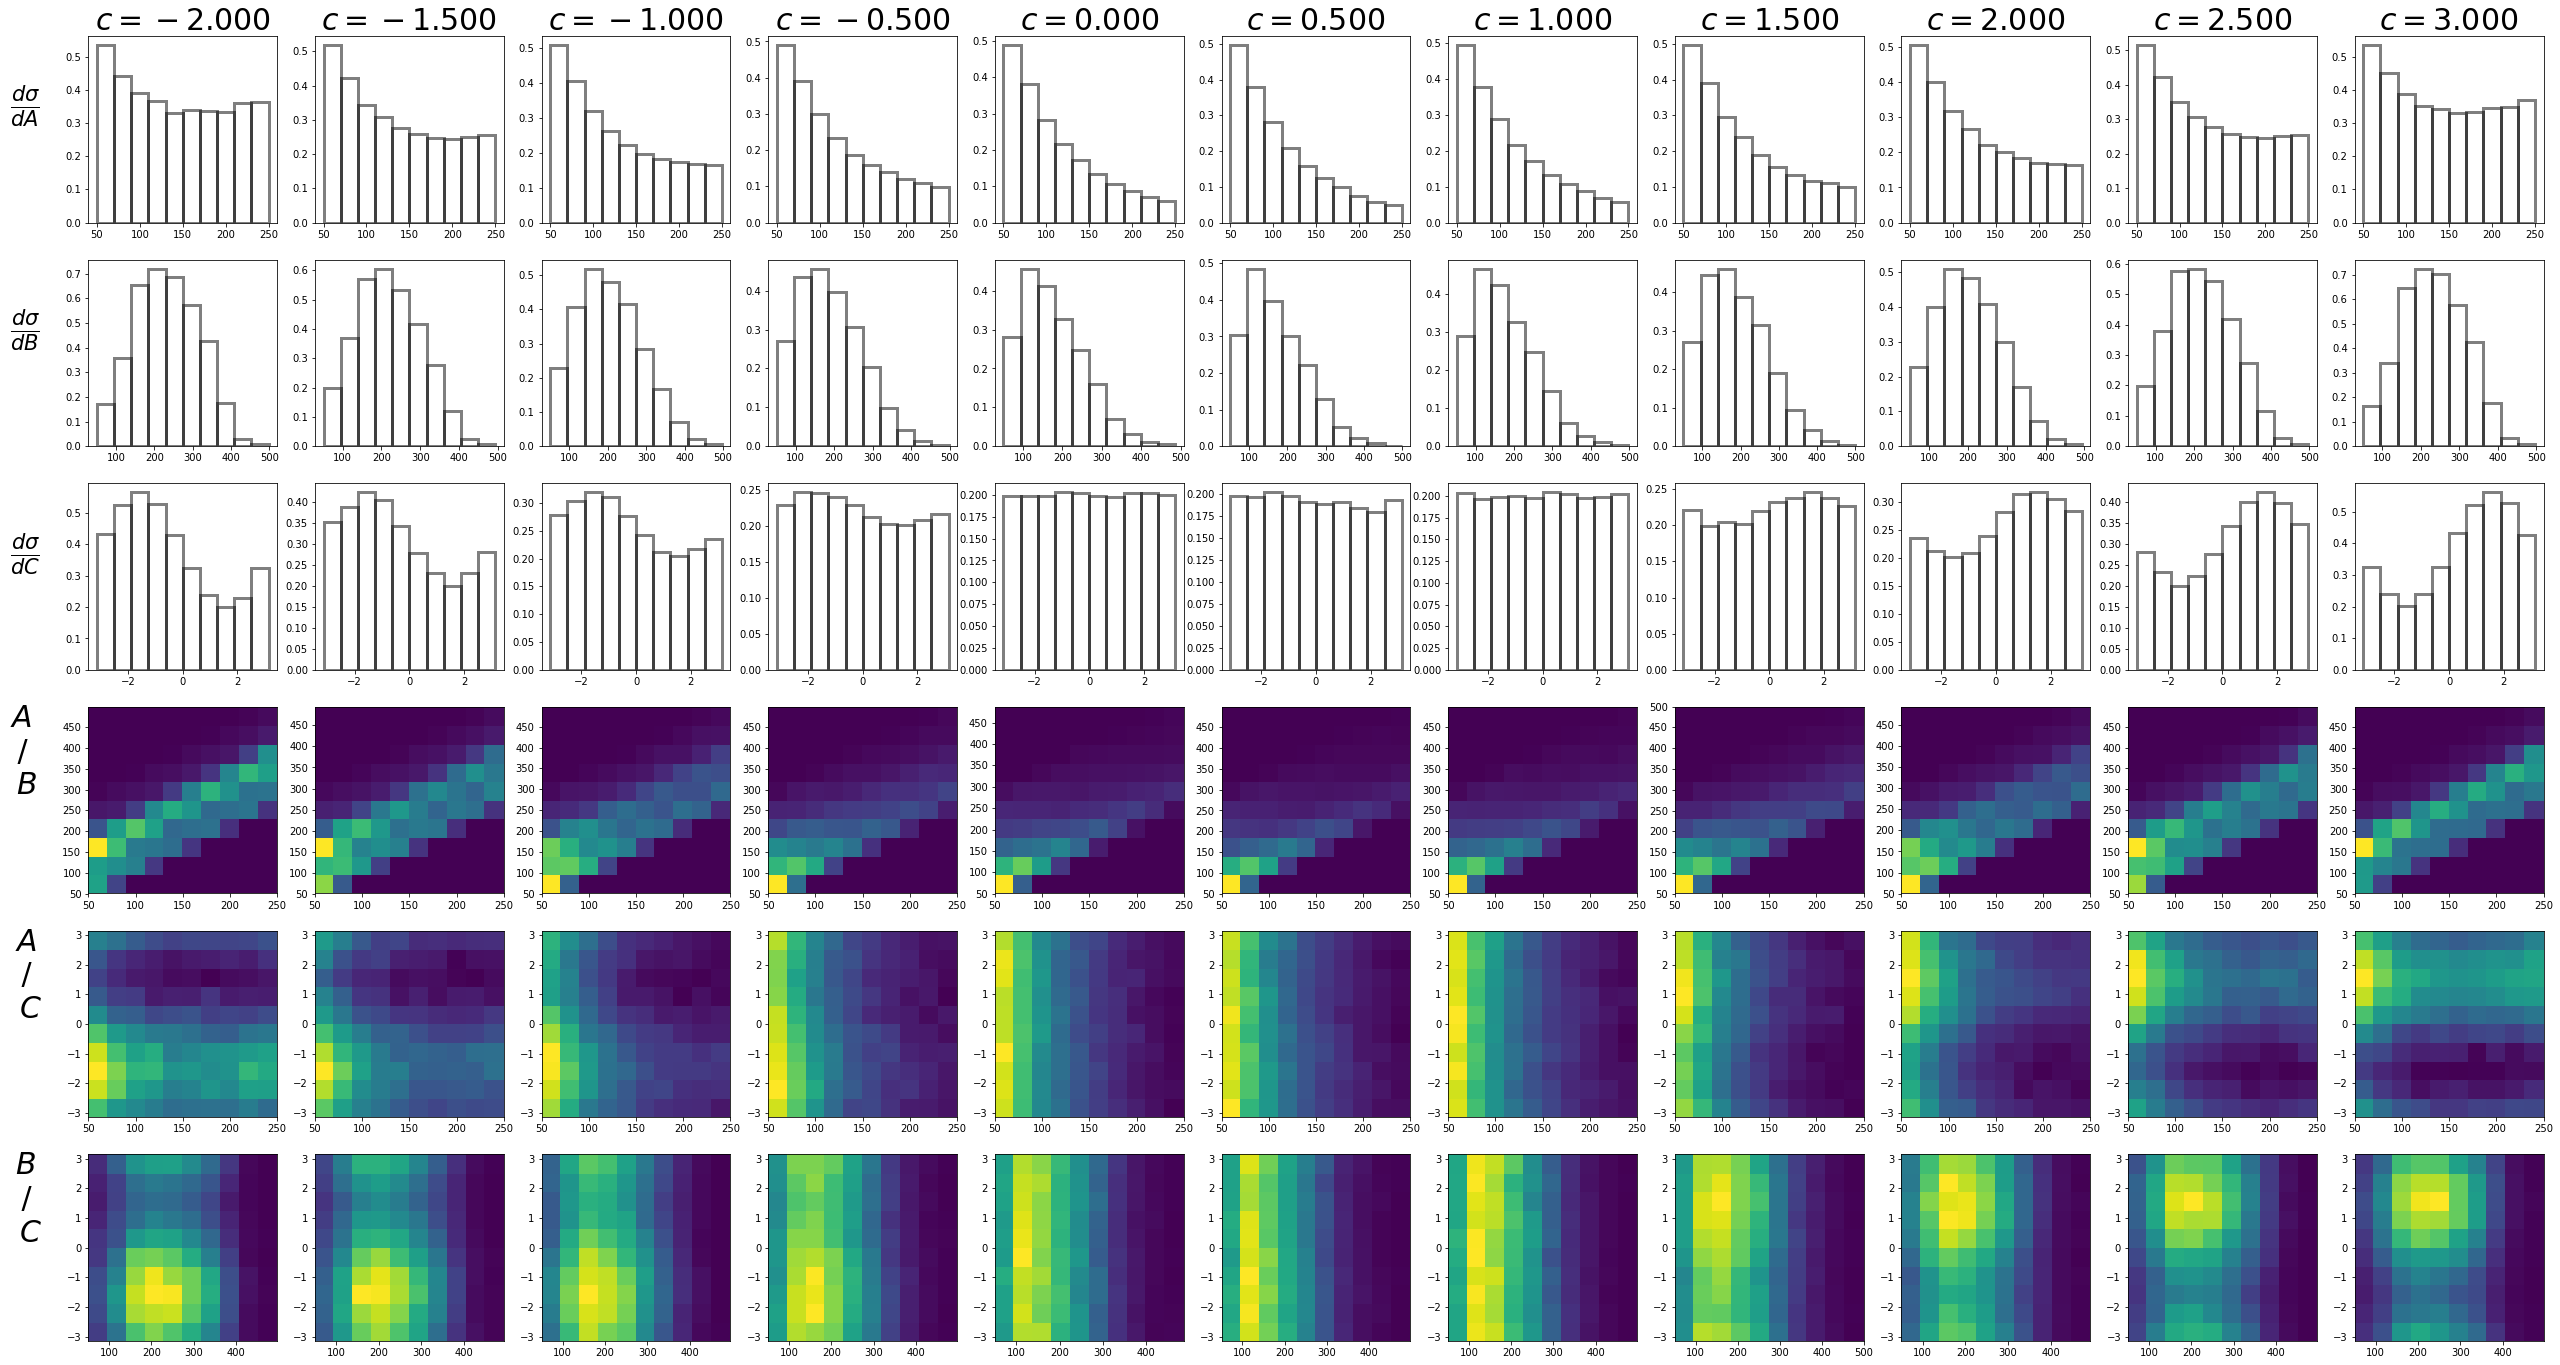

Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets


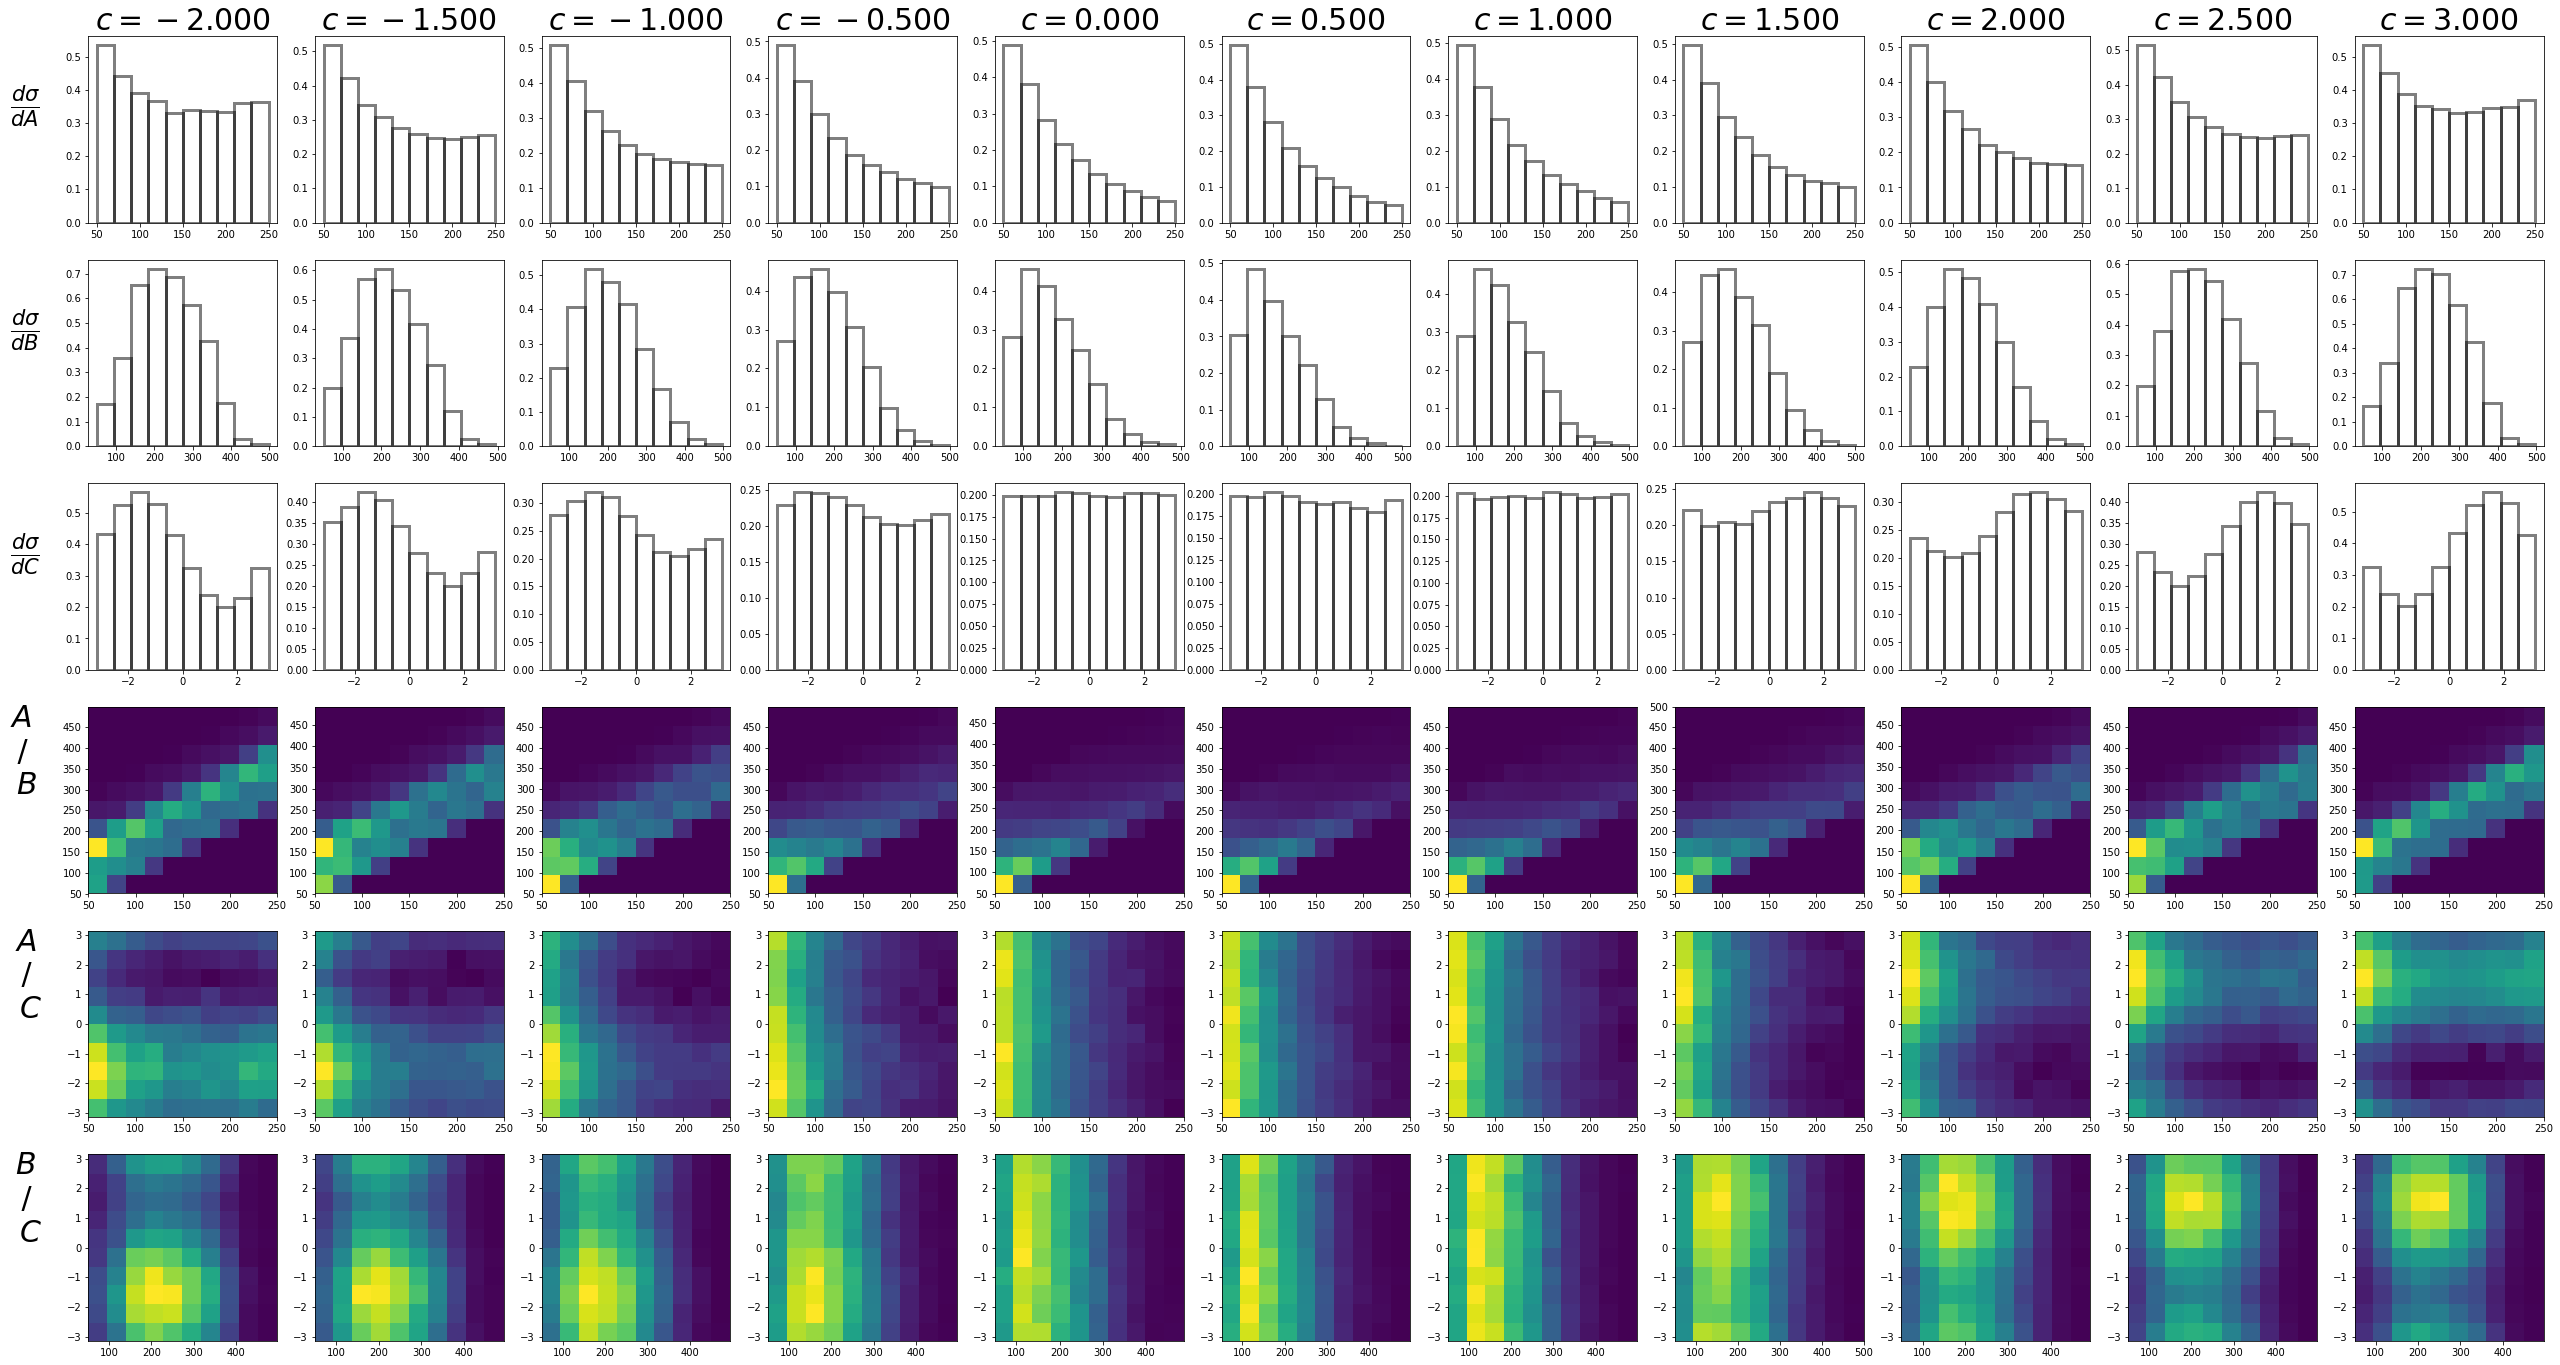

In [5]:
print("Plotting datasets")
#plot_dataset(mu_scan_points, xsections, datasets, weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, datasets, weights)

print("Plotting unwhitened(whitened(datasets)) to show this reconstructs original datasets")
#plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights, ref=(xsec_SM, dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, unwhiten_data(white_datasets), weights)


Plotting whitened datasets


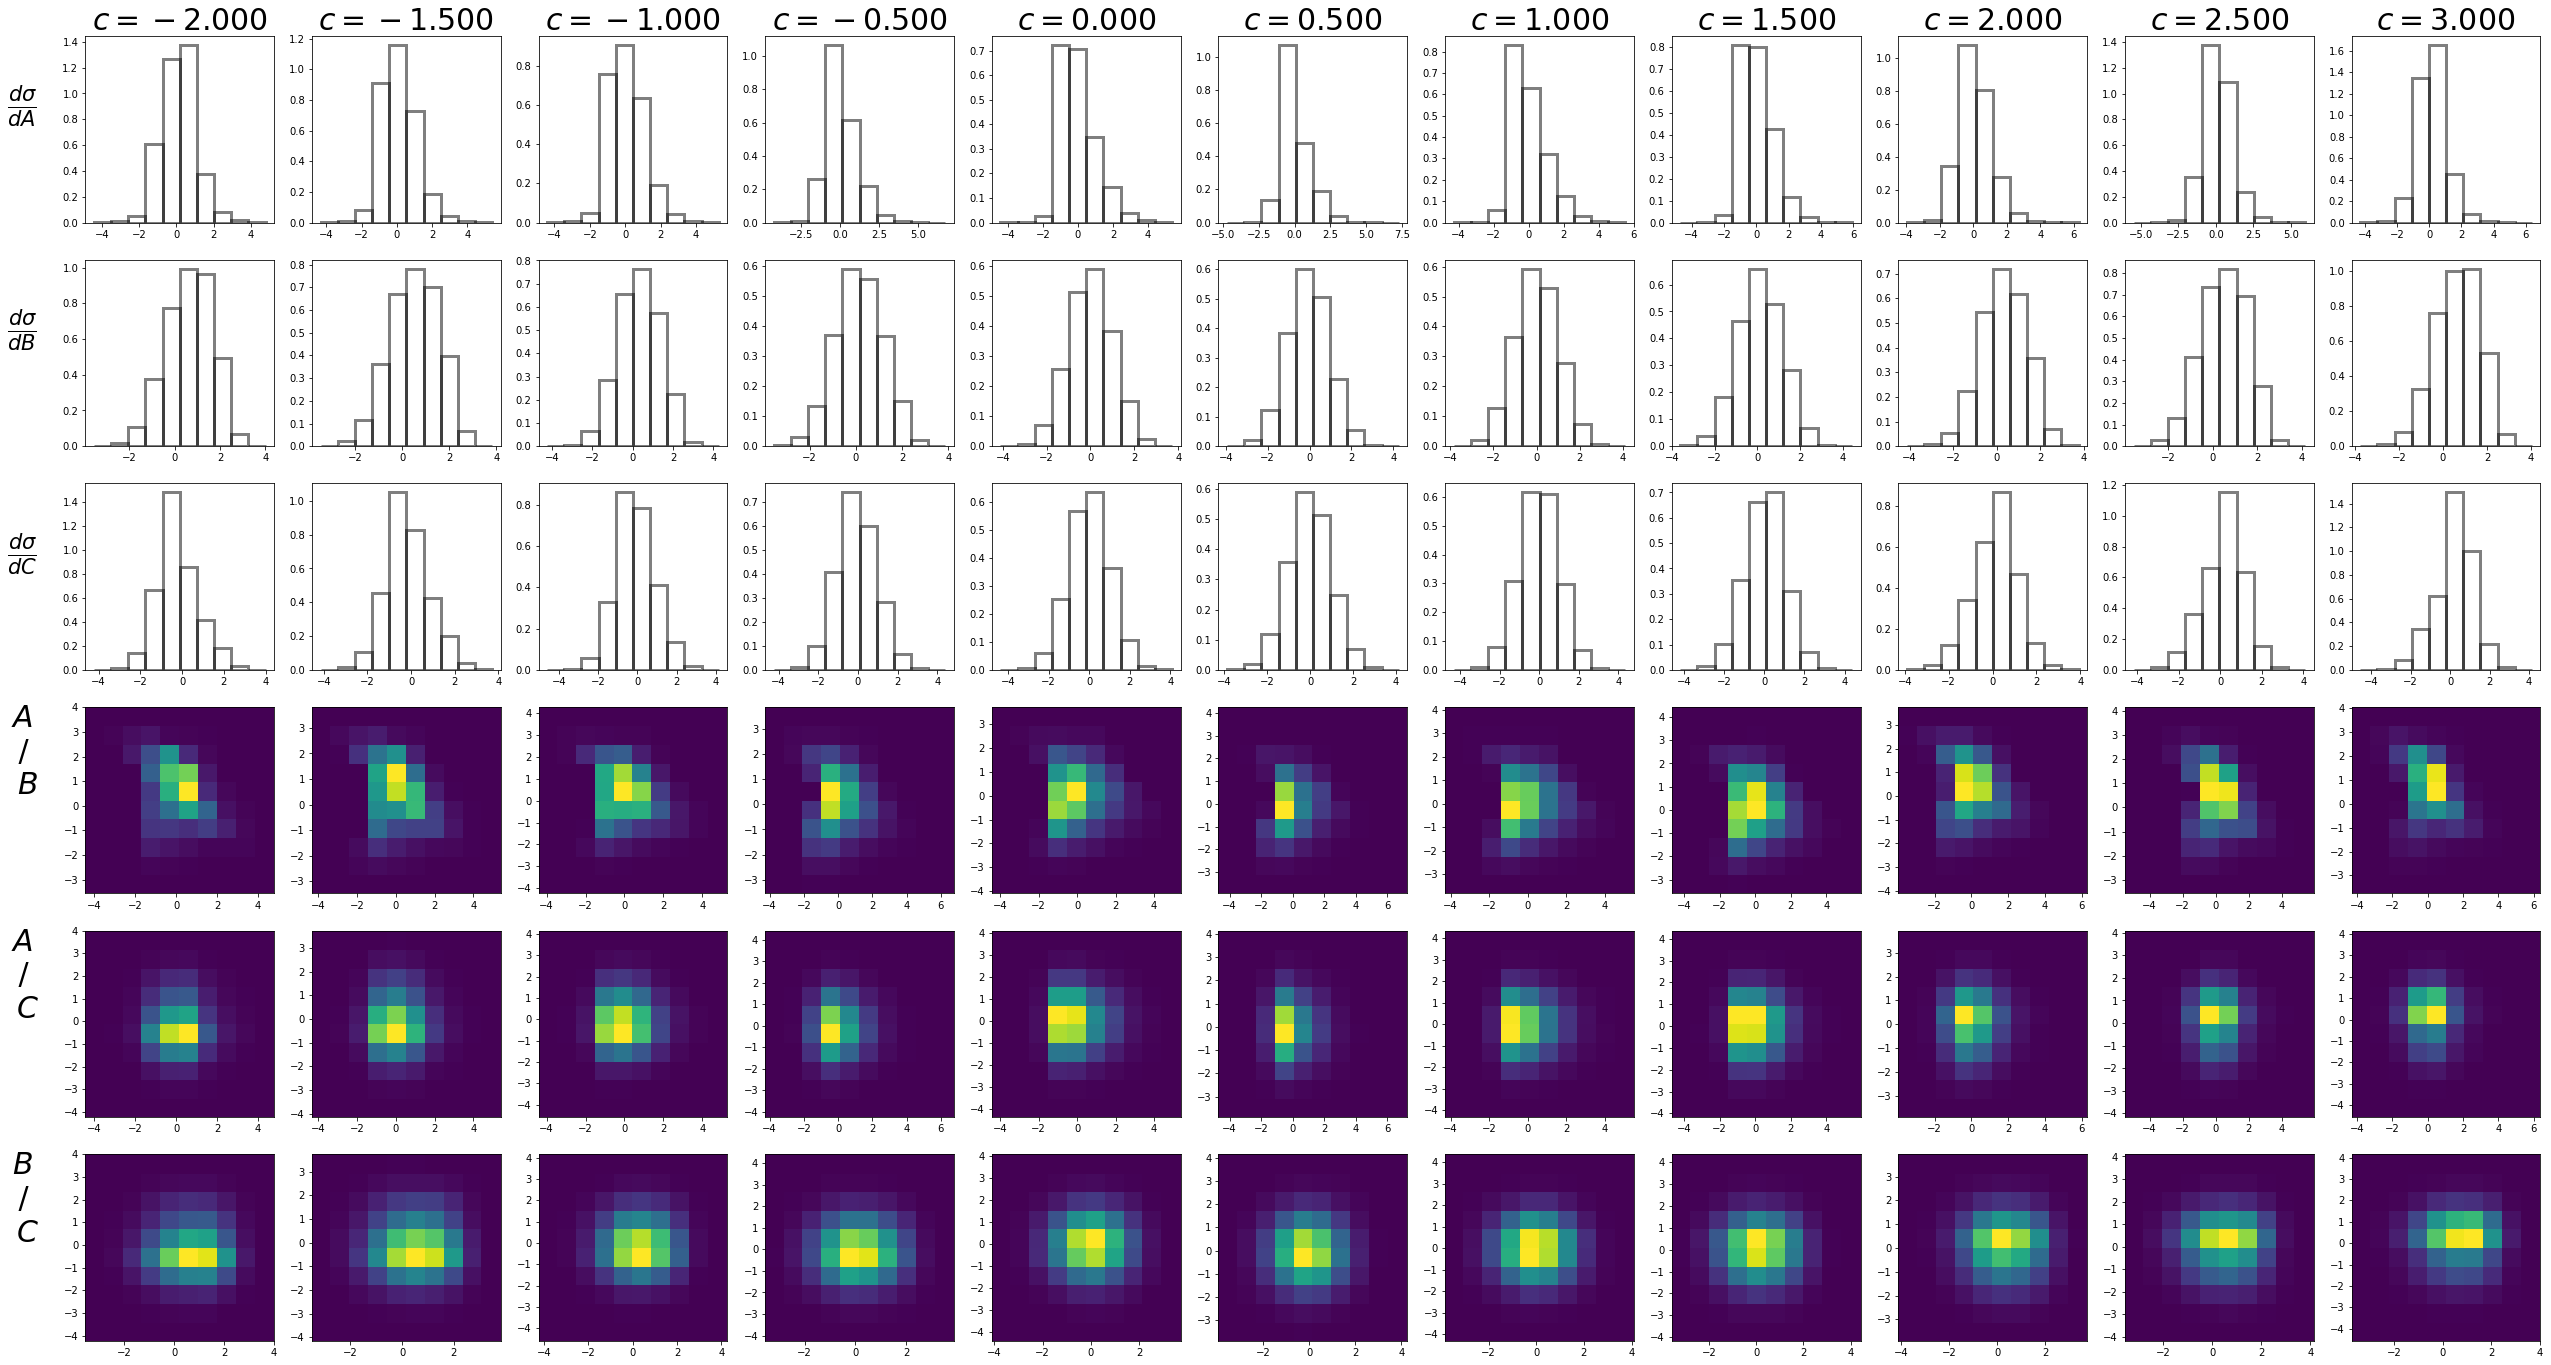

In [6]:
print("Plotting whitened datasets")
#plot_dataset(mu_scan_points, xsections, white_datasets, weights, ref=(xsec_SM, white_dataset_SM, weights_SM))
plot_dataset(mu_scan_points, xsections, white_datasets, weights)

In [15]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, critic_data_input):
    gradients = K.gradients(y_pred, critic_data_input)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)

def WGAN_GP_loss(y_true, y_pred, critic_data_input):
    return wasserstein_loss(y_true, y_pred) + GRADIENT_PENALTY_WEIGHT * gradient_penalty_loss(y_true, y_pred, critic_data_input)
    
    

# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)
    def get_config(self):
        return {'clip_value': self.clip_value}

def create_autoreg_wgan_segment (name, **kwargs) :
    #  Parse arguments
    #
    layer_idx      = int (kwargs.get("layer_idx"     ))
    num_conditions = int (kwargs.get("num_conditions"))
    verbose        = bool(kwargs.get("verbose" , True))
    prev_generator = kwargs.get("prev_generator"  , None)
    
    #  Print a status message
    #
    if verbose : 
        print(f"Creating autoregressive WGAN segment: {name}")
        print(f"  - layer_idx      is {layer_idx}")
        print(f"  - num_conditions is {num_conditions}")
      
    #  Create Inputs for the GAN
    #  
    condition_input   = Input((num_conditions,))
    critic_data_input = Input((layer_idx+1,))
    gen_noise_input   = Input((layer_idx+1,))
    
    #  Create critic
    #
    constraint = None
    if wgan_weight_clipping > 0 : constraint = ClipConstraint(wgan_weight_clipping)
    critic_data      = Dense    (10 , kernel_constraint=constraint)(critic_data_input)
    critic_data      = LeakyReLU(0.2                              )(critic_data      )
    critic_condition = Dense    (10 , kernel_constraint=constraint)(condition_input  )
    critic_condition = LeakyReLU(0.2                              )(critic_condition )
    critic           = Concatenate()([critic_data, critic_condition])
    critic           = Dropout      (0.1                              )(critic)
    critic           = Dense        (20 , kernel_constraint=constraint)(critic)
    critic           = LeakyReLU    (0.2                              )(critic)
    critic           = Dropout      (0.1                              )(critic)
    '''critic           = Dense        (25 , kernel_constraint=constraint)(critic)
    critic           = LeakyReLU    (0.2                              )(critic)
    critic           = Dropout      (0.1                              )(critic)'''
    '''critic           = Dense             (25 )(critic)
    critic           = LeakyReLU         (0.2)(critic)
    critic           = Dropout(0.1)           (critic)'''
    critic           = Dense             (1  , activation="linear")(critic)
    critic           = Model(name=name+"_critic", 
                                   inputs=[critic_data_input, condition_input], 
                                   outputs=[critic])
    critic_loss = wasserstein_loss
    if do_wgan_gp : critic_loss = lambda y_true, y_pred : WGAN_GP_loss(y_true, y_pred, critic_data_input)
    
    if use_Adam_optimiser : critic.compile(loss=critic_loss, optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9))
    else                  : critic.compile(loss=critic_loss, optimizer=RMSprop(learning_rate=1e-6, rho=0))
    if verbose : critic.summary()
    
    #  Process Input objects into the first layers of the layer_idx'th generator
    #
    if layer_idx == 0 :
        gen_observable_noise = gen_noise_input
        gen_all_conditions   = condition_input
    else :
        gen_observable_noise = Lambda(lambda x: x[:, layer_idx])(gen_noise_input)
        gen_observable_noise = Reshape((1,))(gen_observable_noise)
        prev_gen_noise       = Lambda(lambda x: x[:,:layer_idx])(gen_noise_input)
        prev_gen_noise       = Reshape((layer_idx,))(prev_gen_noise)
        prev_observables     = prev_generator([prev_gen_noise, condition_input])
        gen_all_conditions   = Concatenate()([condition_input, prev_observables])                

    #  Create generator
    #
    generator_noise     = Dense    (10   )(gen_observable_noise)
    generator_noise     = LeakyReLU(0.2  )(generator_noise     )
    generator_condition = Dense    (10   )(gen_all_conditions  )
    generator_condition = LeakyReLU(0.2  )(generator_condition )
    generator           = Concatenate()([generator_noise, generator_condition])
    generator           = BatchNormalization()            (generator)
    generator           = Dropout(0.1                    )(generator)
    generator           = Dense  (20                     )(generator)
    generator           = LeakyReLU(0.2                  )(generator)
    generator           = BatchNormalization()            (generator)
    generator           = Dropout(0.1                    )(generator)
    '''generator           = Dense  (25,                    )(generator)
    generator           = LeakyReLU(0.2                  )(generator)
    generator           = Dropout(0.1                    )(generator)'''
    '''generator           = Dense  (25,                    )(generator)
    generator           = LeakyReLU(0.2                  )(generator)
    generator           = Dropout(0.1                    )(generator)'''
    if do_use_critic_tanh : generator = Dense (1 , activation="tanh")(generator)
    else                  : generator = Dense (1 , activation="linear")(generator)
    if layer_idx > 0 : generator = Concatenate()([prev_observables, generator])
    generator           = Model(name=name+"_generator", 
                                inputs=[gen_noise_input, condition_input], 
                                outputs=[generator])
    if verbose : generator.summary()

    GAN = critic([generator([gen_noise_input, condition_input]), condition_input])
    GAN = Model([gen_noise_input, condition_input], GAN, name=name)
    critic.trainable = False
    
    if use_Adam_optimiser : GAN.compile(loss=wasserstein_loss, optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9))
    else                  : GAN.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=1e-6, rho=0))
        #GAN.compile(loss=wasserstein_loss, optimizer=SGD(learning_rate=1e-6)) # optimizer=RMSprop(learning_rate=1e-6, rho=0)
    if verbose : GAN.summary()
        
    return critic, generator, GAN
           
def create_autoreg_wgan (name, **kwargs) :
    num_conditions  = int (kwargs.get("num_conditions" ))
    num_observables = int (kwargs.get("num_observables"))
    verbose         = bool(kwargs.get("verbose"  , True))

    if verbose : 
        print(f"Creating WGAN: {name}")
        print(f"  - num_observables is {num_observables}")
        print(f"  - num_conditions  is {num_conditions}")
    
    layer_critics, layer_generators, layer_GANs = [], [], []
    for i in range(num_observables):
        prev_generator = None
        if len(layer_generators) > 0 : prev_generator = layer_generators[-1]
        critic_i, generator_i, GAN_i = create_autoreg_wgan_segment(name              = f"{name}_observable{i}",
                                                                   layer_idx         = i,
                                                                   num_conditions    = num_conditions,
                                                                   prev_generator    = prev_generator,
                                                                   verbose           = verbose)
        critic_i.trainable, generator_i.trainable = False, False
        layer_critics             .append(critic_i                  )
        layer_generators          .append(generator_i               )
        layer_GANs                .append(GAN_i                     )
    
    return layer_critics, layer_generators, layer_GANs


In [16]:

layer_critics, layer_generators, layer_GANs = create_autoreg_wgan("autoreg_GAN", 
                                                                  num_conditions=1, 
                                                                  num_observables=3,
                                                                  verbose=False)


In [17]:
def get_generator_noise_samples (batch_size, train_points_c, ndim, add_data_noise) :
    low_lim, upp_lim, noise_fraction = add_data_noise
    ngen = int(noise_fraction*batch_size)
    hyperparams = np.concatenate([np.full(fill_value=c, shape=(ngen, 1)) for c in train_points_c])
    return low_lim+np.random.rand(ngen*len(train_points_c), ndim)*(upp_lim-low_lim), hyperparams

def get_noise (batch_size, train_points_c, GAN_noise_size) :
    hyperparams = np.concatenate([np.full(fill_value=c, shape=(batch_size, 1)) for c in train_points_c])
    return np.random.normal(size=(batch_size*len(train_points_c), GAN_noise_size)), hyperparams

def get_train_data (batch_size, train_points_c, datasets, max_axis) :
    data_batch  = np.concatenate([ds[np.random.randint(0, len(ds), batch_size),:max_axis] for c, ds in datasets.items()])
    if len(data_batch.shape) == 1 :
        data_batch = data_batch.reshape((data_batch.shape[0],1))
    hyperparams = np.concatenate([np.full(fill_value=c, shape=(batch_size, 1)) for c in train_points_c])
    return data_batch, hyperparams
    
def get_train_fakes (batch_size, train_points_c, GAN_noise_size, generator) :
    noise, hyperparams = list(get_noise(batch_size, train_points_c, GAN_noise_size))
    fakes_batch = generator.predict([noise, hyperparams])
    return fakes_batch, hyperparams

'''def get_batch_size (epoch_idx, min_batch_size, max_batch_size, batch_update_per_epoch) :
    return int(np.min([min_batch_size + batch_update_per_epoch*epoch_idx, max_batch_size]))'''


'def get_batch_size (epoch_idx, min_batch_size, max_batch_size, batch_update_per_epoch) :\n    return int(np.min([min_batch_size + batch_update_per_epoch*epoch_idx, max_batch_size]))'

In [18]:
def energy_test_stat (ds1, ds2) :
    E1, E2, E3 = 0., 0., 0.
    n1, n2 = len(ds1), len(ds2)
    for x1 in ds1 :
        for x2 in ds2 :
            res = x2 - x1
            E1 = E1 + np.matmul(res, res)
    E1 = np.sqrt(E1) / n1 / n2
    for x1 in ds1 :
        for x2 in ds1 :
            res = x2 - x1
            E2 = E2 + np.matmul(res, res)
    E2 = np.sqrt(E2) / n1 / n1
    for x1 in ds2 :
        for x2 in ds2 :
            res = x2 - x1
            E3 = E3 + np.matmul(res, res)
    E3 = np.sqrt(E3) / n1 / n1
    return 2*E1 - E2 - E3

def get_Et_thresholds (batch_size, threshold, num_toys=10) :
    toy_energy_values = {}
    for mu in mu_scan_points :
        toy_energy_values [mu] = []
    
    sys.stdout.write("Throwing toys...")
    for i in range(num_toys) :
        sys.stdout.write(f"\rThrowing {num_toys} toys... [{int(100.*(i+1)/num_toys)}%]")
        toy1_data , toy1_data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=1)
        toy2_data , toy2_data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=1)
        for mu in mu_scan_points :
            toy1_data_mu  = np.array([x for x,c in zip(toy1_data, toy1_data_conditions) if c == mu])
            toy2_data_mu  = np.array([x for x,c in zip(toy2_data, toy2_data_conditions) if c == mu])
            toy_energy_values[mu].append(energy_test_stat(toy1_data_mu, toy2_data_mu))
    sys.stdout.write("\n")
    
    num_mu_scan_points = len(mu_scan_points)
    
    fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
    Et_thresholds = {}
    for ax_idx, mu in enumerate(mu_scan_points) :
        vals = sorted(toy_energy_values[mu])
        Et_threshold      = 2*vals[min(int(threshold*len(vals)), len(vals)-1)]
        Et_thresholds[mu] = Et_threshold
        ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
        ax.hist(vals, color="green", alpha=0.5)
        ax.axvline(Et_threshold, linestyle="--", c="k", linewidth=2)
        ax.set_title(f"$\mu = {mu:.2f}$")
        ax.set_xlabel("Energy test", fontsize=12, labelpad=15)
    plt.show()
                
    return Et_thresholds

In [19]:

initial_batch_size, batch_update_factor, max_batch_size = 100, 2, 1000
max_epochs                   = 100000000
max_critic_updates_per_epoch = 5
update_critic_fixed_ntimes   = True
max_gen_updates_per_epoch    = 1
add_generator_noise          = None # [-5, 5, 0.1]

epoch_print_interval = 500

energy_test_threshold = 1
energy_test_ntoys     = 10


Getting initial Et thresholds
Throwing 10 toys... [100%]


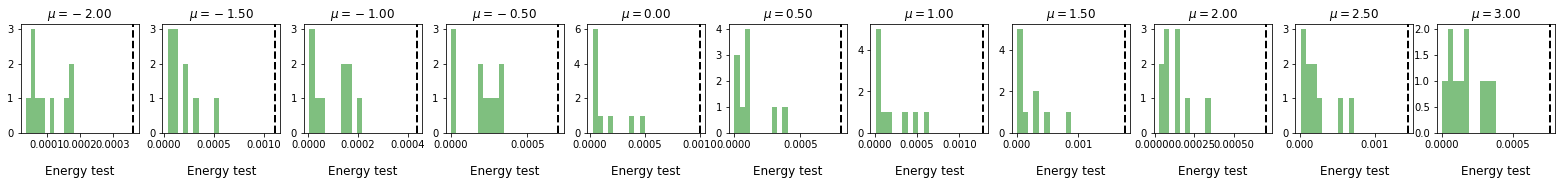

Epoch 0 GAN loss is 0.14428526163101196
Batch size is 100
Energy test [mu = -2.00] = 0.00263, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00261, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00362, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00448, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00387, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00499, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00392, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00446, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00438, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00472, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00421, with threshold of 0.00076


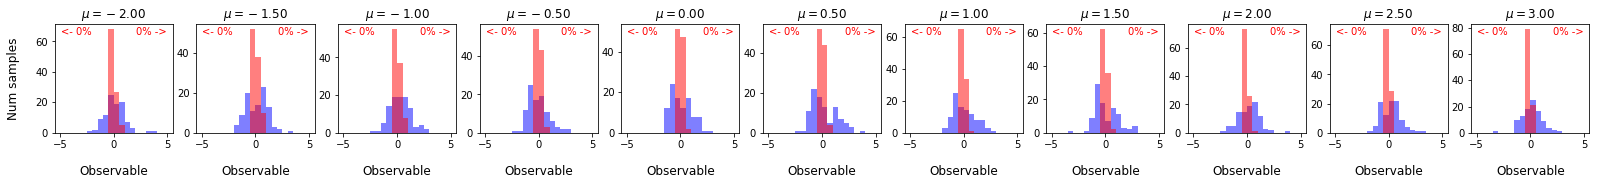

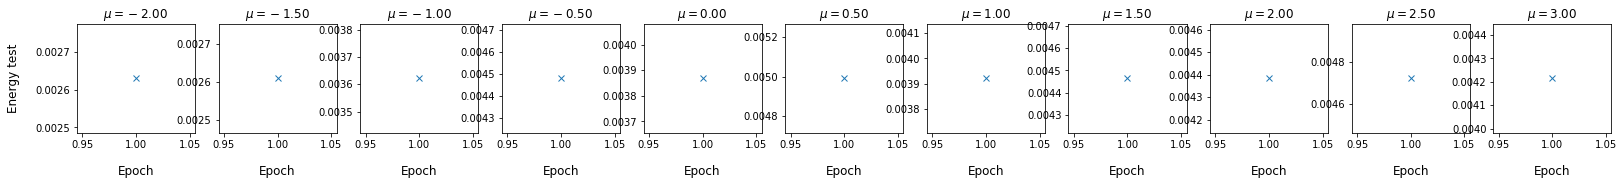

Epoch 500 GAN loss is 0.1443265676498413
Batch size is 100
Energy test [mu = -2.00] = 0.00159, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00190, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00003, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00080, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00046, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00089, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00213, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00211, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00192, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00265, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00586, with threshold of 0.00076


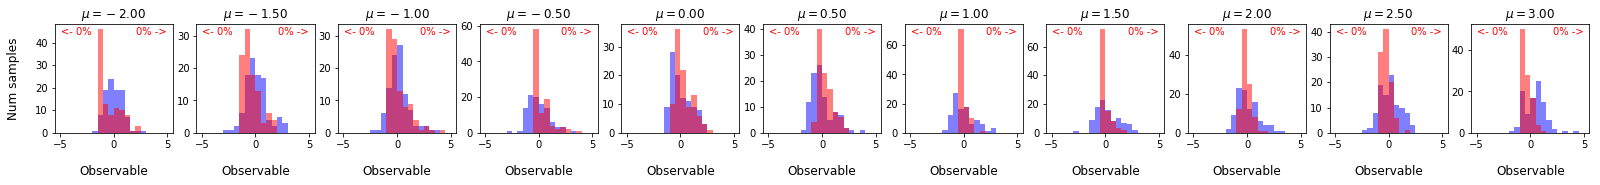

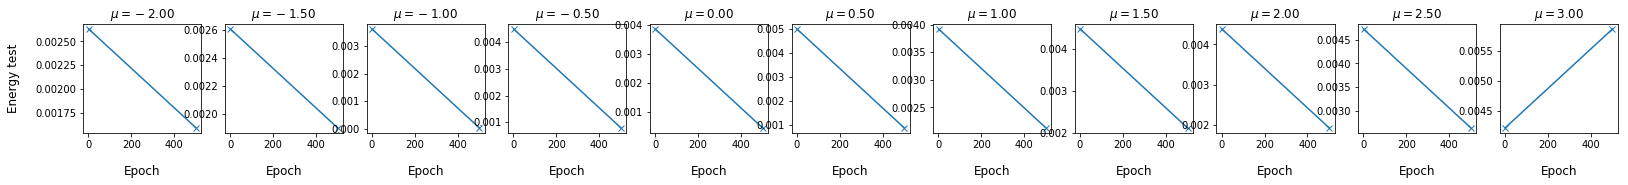

Epoch 1000 GAN loss is 0.1238146424293518
Batch size is 100
Energy test [mu = -2.00] = 0.00618, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00243, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00001, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00066, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00341, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00108, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00133, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00187, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00259, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00078, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00197, with threshold of 0.00076


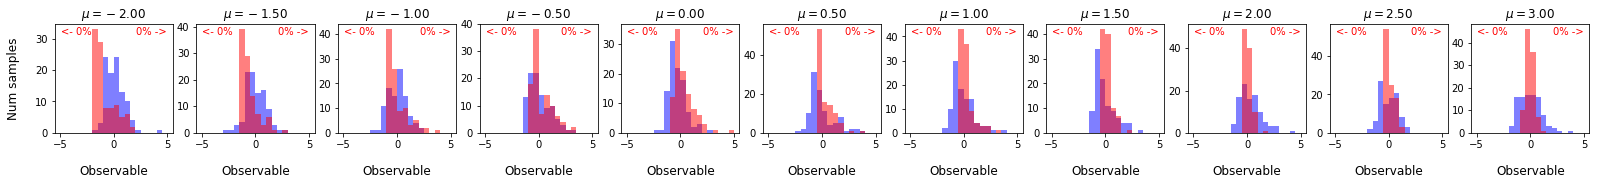

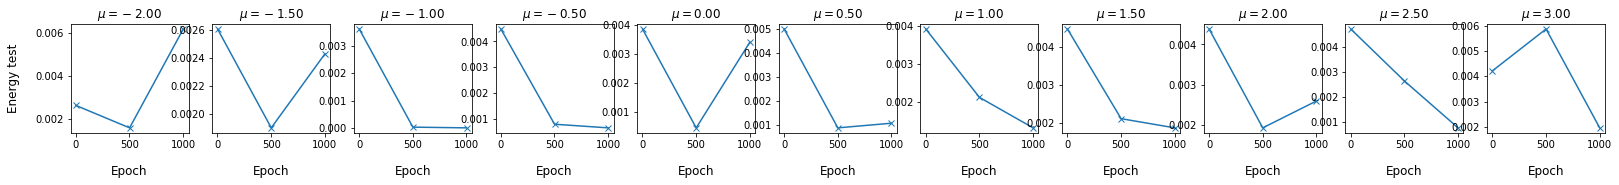

Epoch 1500 GAN loss is 0.11984945088624954
Batch size is 100
Energy test [mu = -2.00] = 0.01234, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00545, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00122, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00010, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00114, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00194, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00296, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00210, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00274, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00119, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00152, with threshold of 0.00076


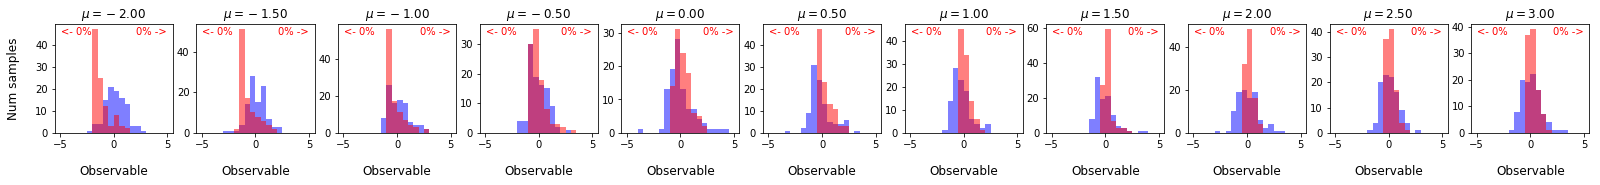

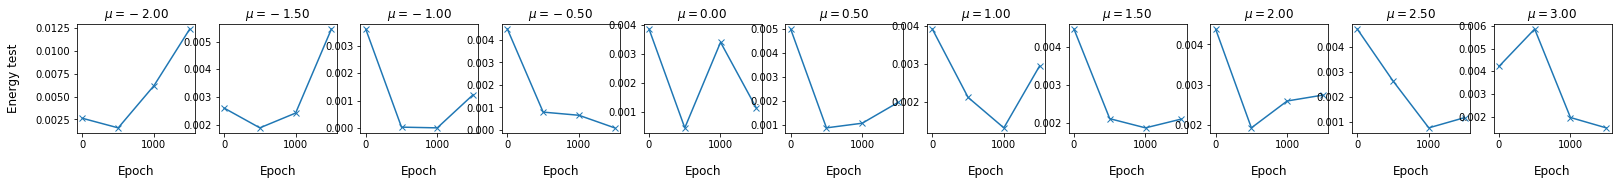

Epoch 2000 GAN loss is 0.10083124041557312
Batch size is 100
Energy test [mu = -2.00] = 0.01479, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00887, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00554, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00006, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00105, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00203, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00218, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00269, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00285, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00491, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00397, with threshold of 0.00076


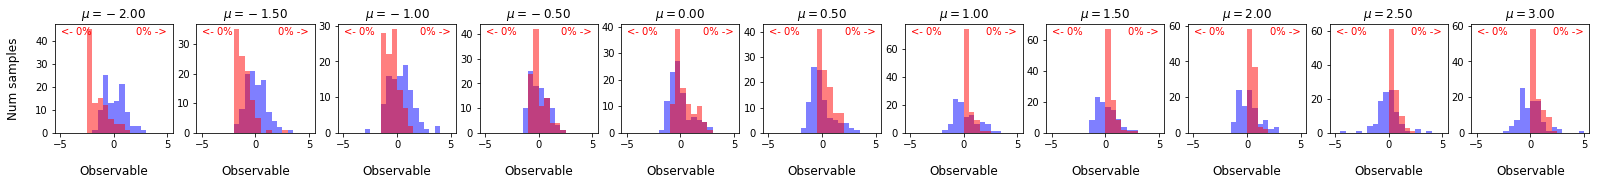

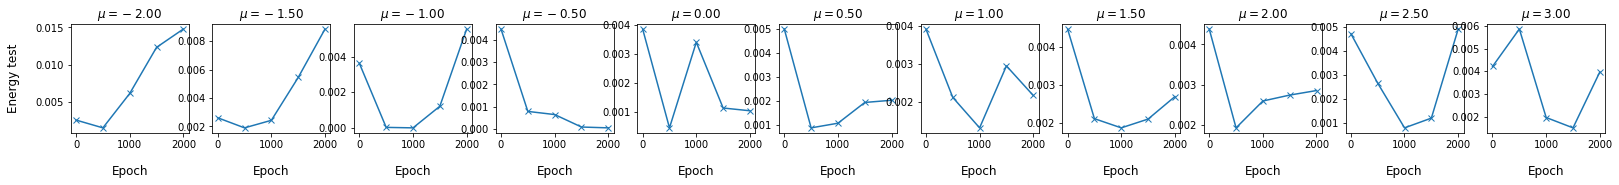

Epoch 2500 GAN loss is 0.09099937230348587
Batch size is 100
Energy test [mu = -2.00] = 0.01765, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01409, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00429, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00065, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00086, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00256, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00421, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00519, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00706, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00785, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00527, with threshold of 0.00076


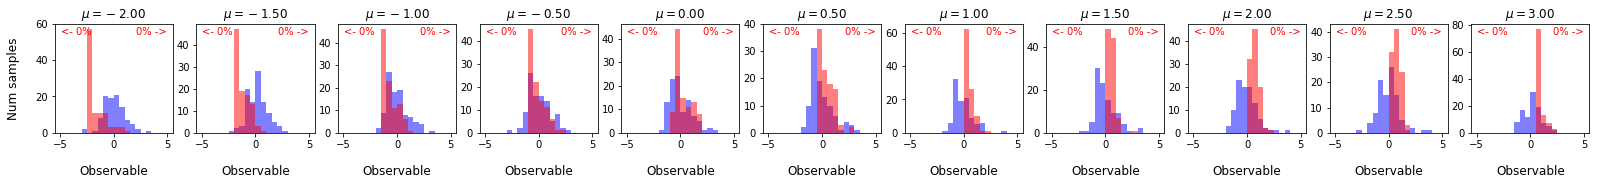

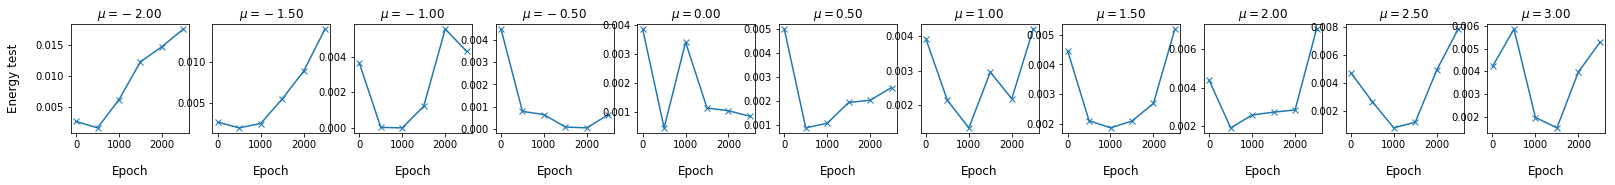

Epoch 3000 GAN loss is 0.07010427862405777
Batch size is 100
Energy test [mu = -2.00] = 0.02397, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01253, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00532, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00166, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00048, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00341, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00517, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00747, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00646, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00934, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01039, with threshold of 0.00076


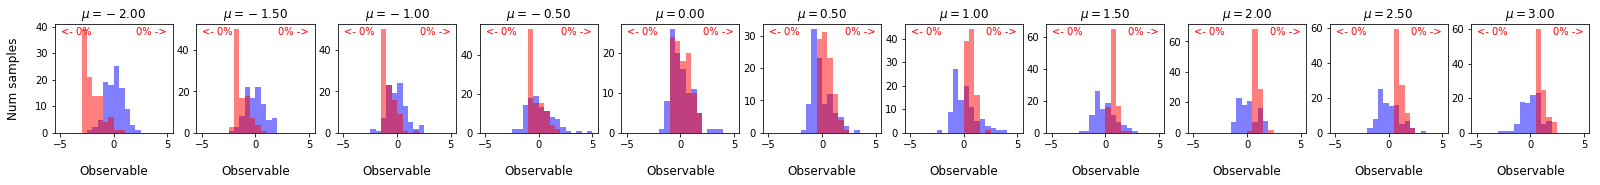

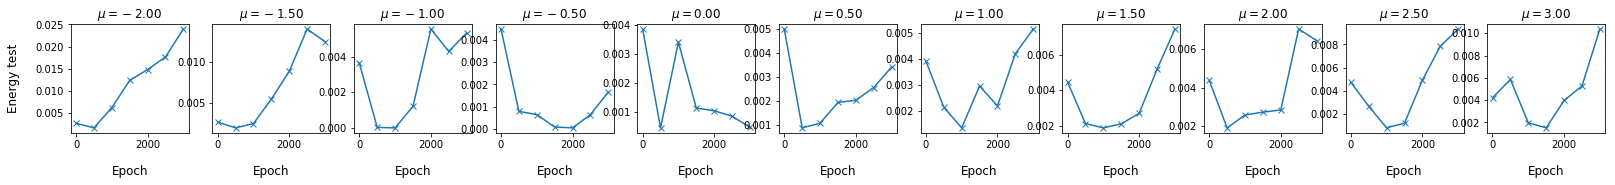

Epoch 3500 GAN loss is 0.08223976939916611
Batch size is 100
Energy test [mu = -2.00] = 0.03141, with threshold of 0.00036
Energy test [mu = -1.50] = 0.02155, with threshold of 0.00111
Energy test [mu = -1.00] = 0.01137, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00218, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00067, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00546, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00487, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00935, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00877, with threshold of 0.00070
Energy test [mu = 2.50] = 0.01184, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01501, with threshold of 0.00076


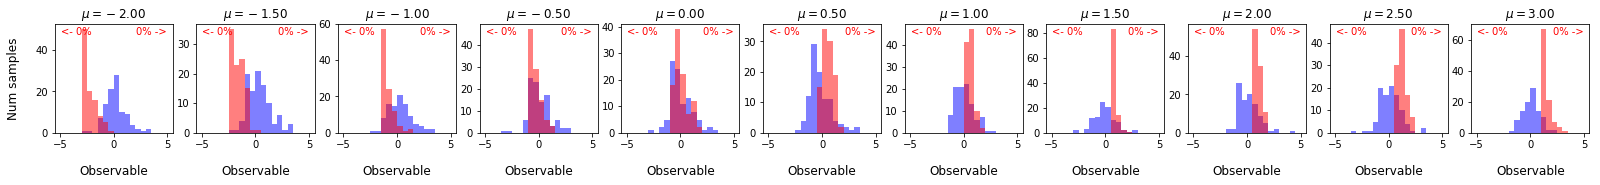

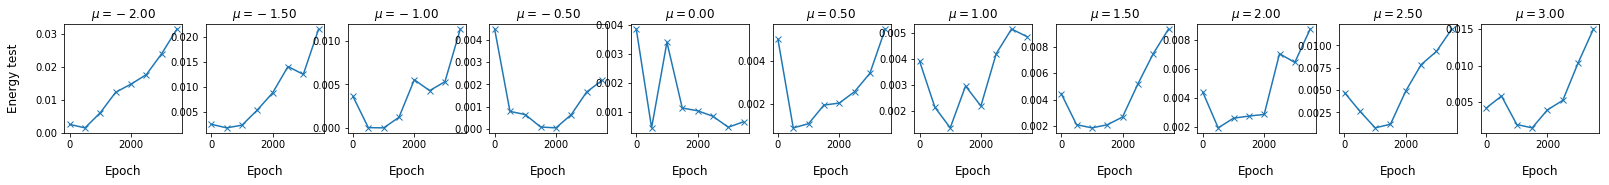

Epoch 4000 GAN loss is 0.08470629900693893
Batch size is 100
Energy test [mu = -2.00] = 0.03275, with threshold of 0.00036
Energy test [mu = -1.50] = 0.02111, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00904, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00540, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00176, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00357, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00679, with threshold of 0.00128
Energy test [mu = 1.50] = 0.01246, with threshold of 0.00175
Energy test [mu = 2.00] = 0.01213, with threshold of 0.00070
Energy test [mu = 2.50] = 0.01455, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01479, with threshold of 0.00076


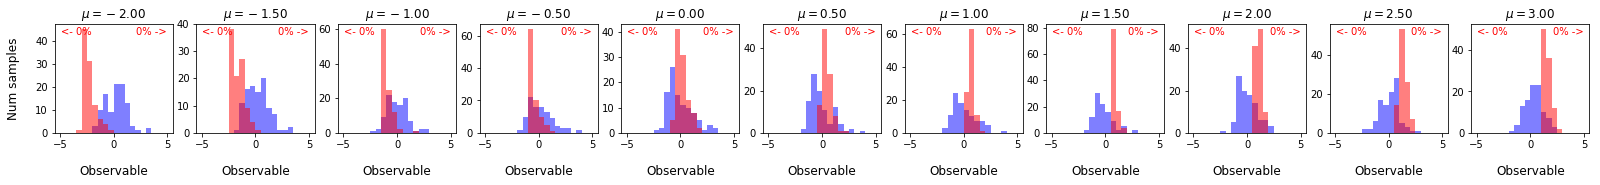

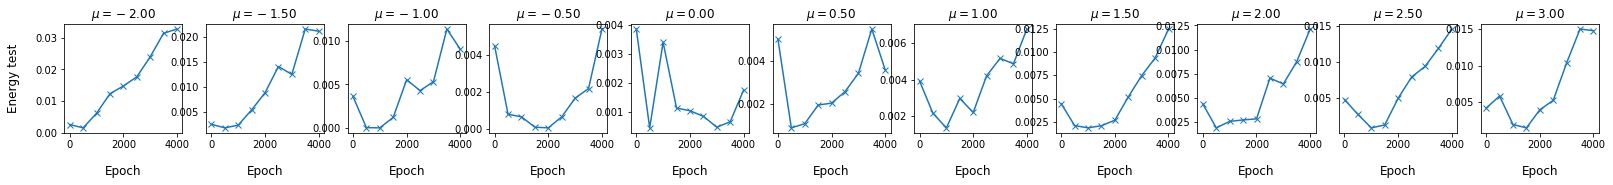

Epoch 4500 GAN loss is 0.08467929810285568
Batch size is 100
Energy test [mu = -2.00] = 0.03455, with threshold of 0.00036
Energy test [mu = -1.50] = 0.02165, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00695, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00147, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00106, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00639, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00754, with threshold of 0.00128
Energy test [mu = 1.50] = 0.01009, with threshold of 0.00175
Energy test [mu = 2.00] = 0.01206, with threshold of 0.00070
Energy test [mu = 2.50] = 0.01309, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01708, with threshold of 0.00076


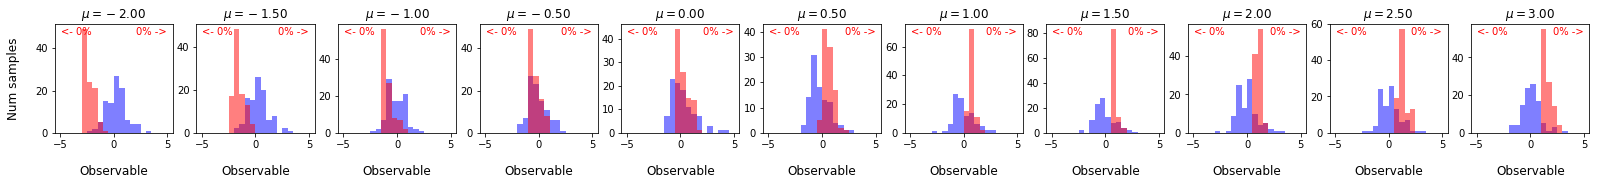

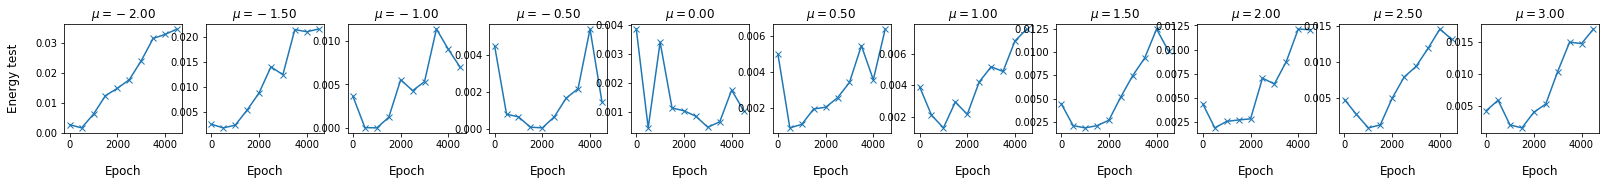

Epoch 5000 GAN loss is 0.09372035413980484
Batch size is 100
Energy test [mu = -2.00] = 0.02617, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01601, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00738, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00254, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00185, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00396, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00718, with threshold of 0.00128
Energy test [mu = 1.50] = 0.01044, with threshold of 0.00175
Energy test [mu = 2.00] = 0.01156, with threshold of 0.00070
Energy test [mu = 2.50] = 0.01194, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01315, with threshold of 0.00076


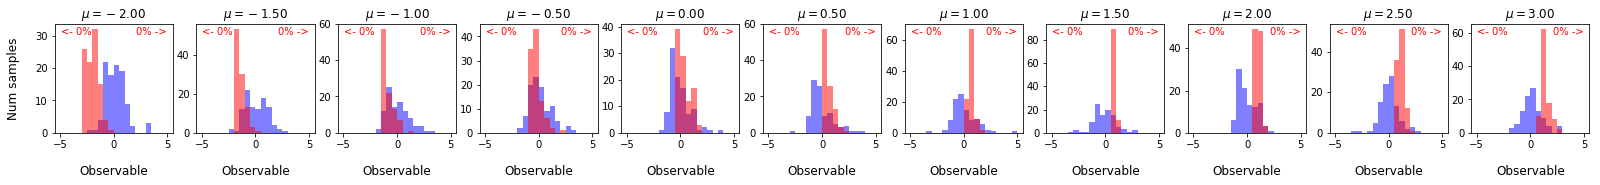

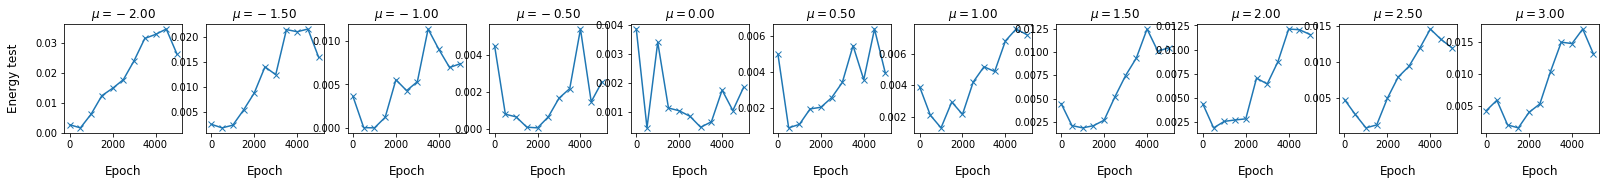

Epoch 5500 GAN loss is 0.09962375462055206
Batch size is 100
Energy test [mu = -2.00] = 0.02453, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01514, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00595, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00127, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00228, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00436, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00556, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00783, with threshold of 0.00175
Energy test [mu = 2.00] = 0.01044, with threshold of 0.00070
Energy test [mu = 2.50] = 0.01152, with threshold of 0.00145
Energy test [mu = 3.00] = 0.01065, with threshold of 0.00076


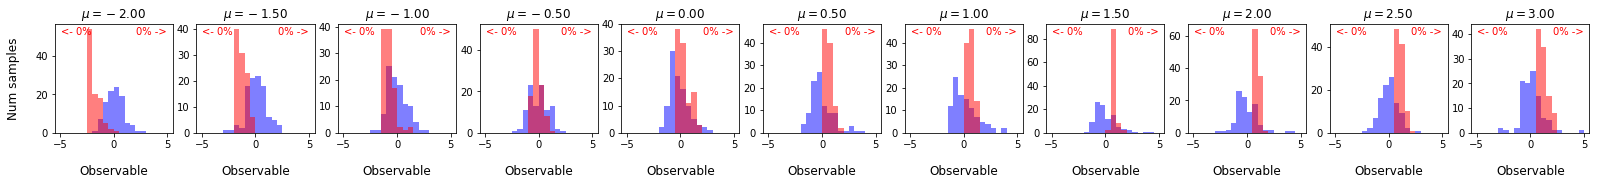

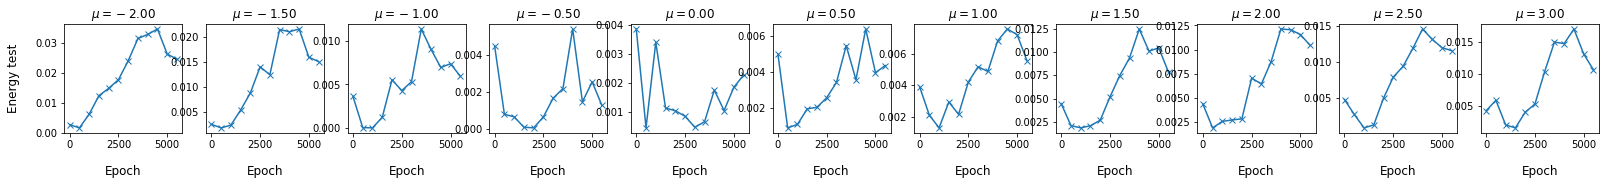

Epoch 6000 GAN loss is 0.09375958889722824
Batch size is 100
Energy test [mu = -2.00] = 0.02149, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01014, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00598, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00157, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00264, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00413, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00566, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00664, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00740, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00907, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00747, with threshold of 0.00076


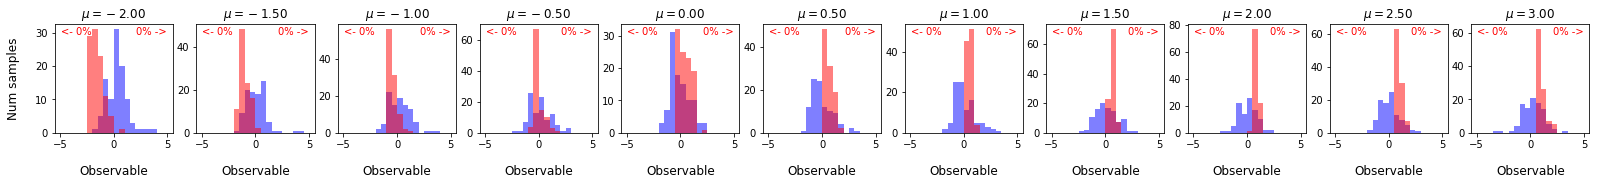

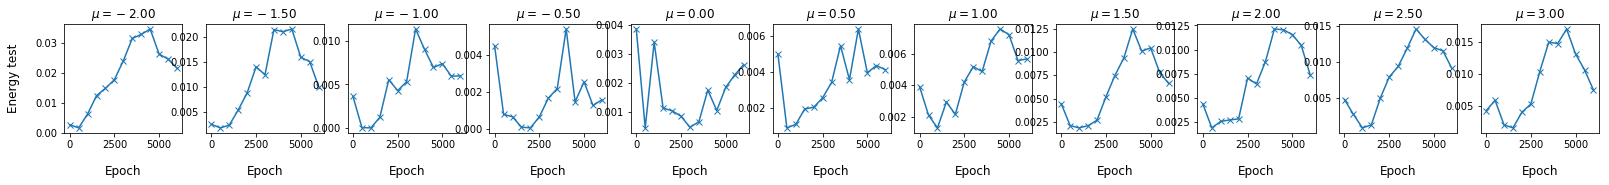

Epoch 6500 GAN loss is 0.09858893603086472
Batch size is 100
Energy test [mu = -2.00] = 0.01919, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00678, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00257, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00267, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00325, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00332, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00524, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00586, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00718, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00561, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00851, with threshold of 0.00076


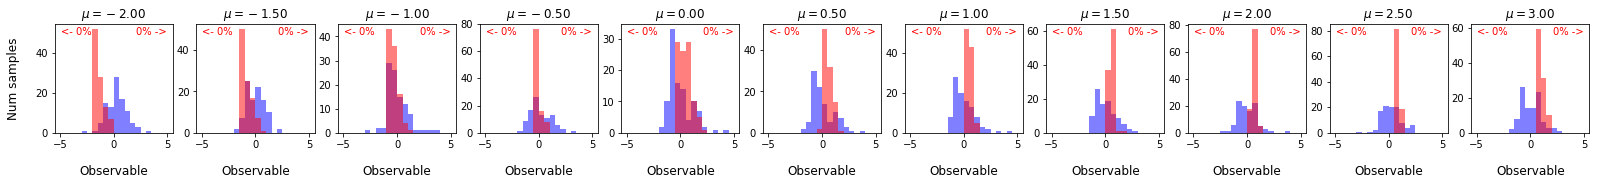

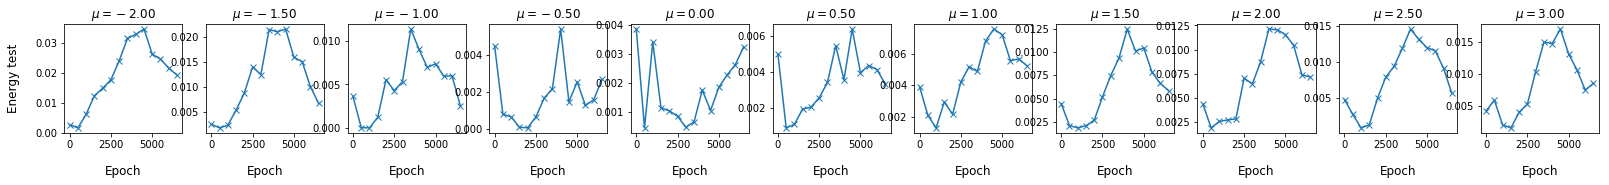

Epoch 7000 GAN loss is 0.10948352515697479
Batch size is 100
Energy test [mu = -2.00] = 0.01320, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00933, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00160, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00184, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00213, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00328, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00609, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00532, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00701, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00527, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00812, with threshold of 0.00076


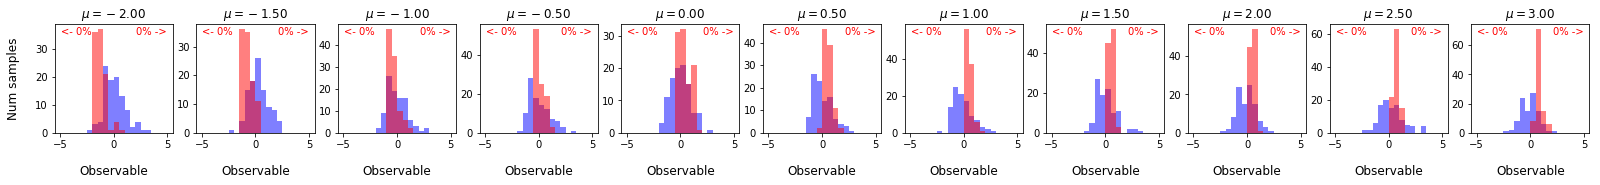

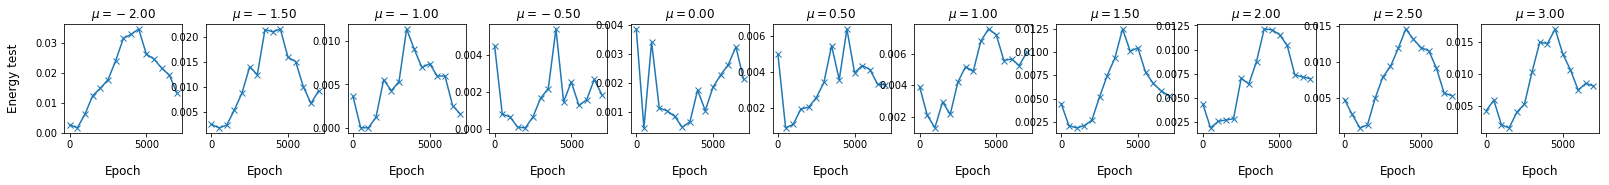

Epoch 7500 GAN loss is 0.08145420253276825
Batch size is 100
Energy test [mu = -2.00] = 0.00956, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00514, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00456, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00129, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00271, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00324, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00541, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00464, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00734, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00538, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00513, with threshold of 0.00076


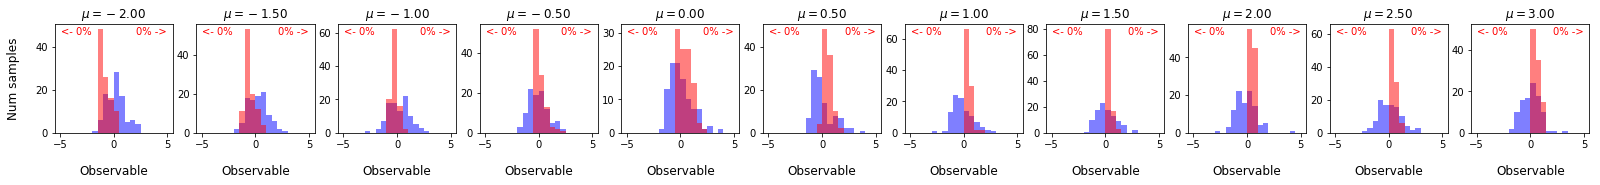

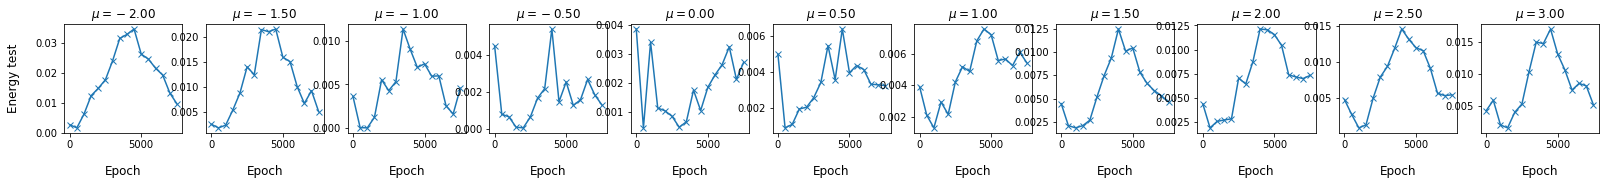

Epoch 8000 GAN loss is 0.07396279275417328
Batch size is 100
Energy test [mu = -2.00] = 0.00577, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00348, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00119, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00248, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00330, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00445, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00520, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00385, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00499, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00464, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00454, with threshold of 0.00076


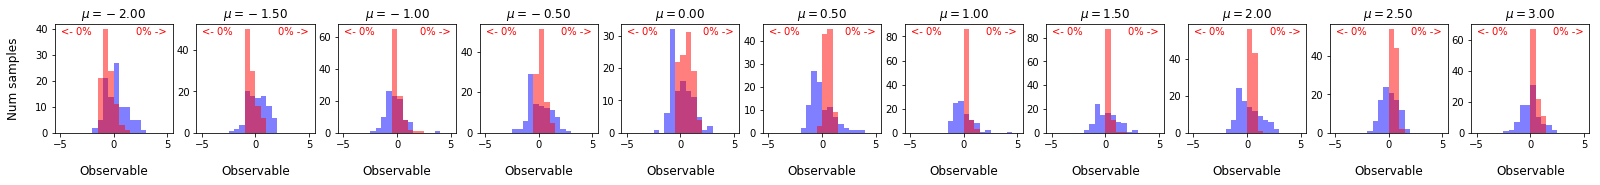

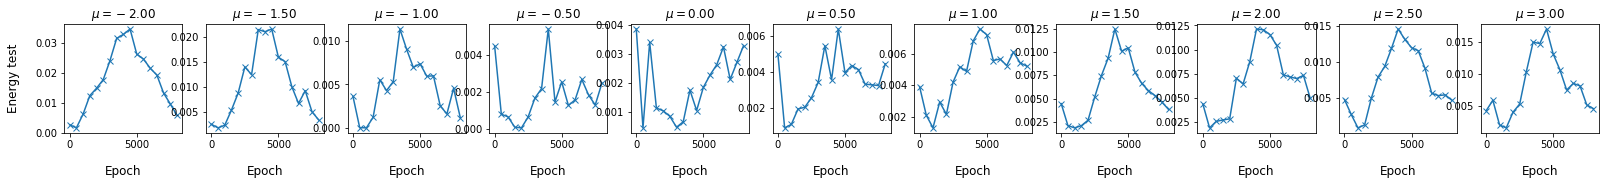

Epoch 8500 GAN loss is 0.0876568928360939
Batch size is 100
Energy test [mu = -2.00] = 0.00357, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00227, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00184, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00230, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00187, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00341, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00395, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00444, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00477, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00402, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00352, with threshold of 0.00076


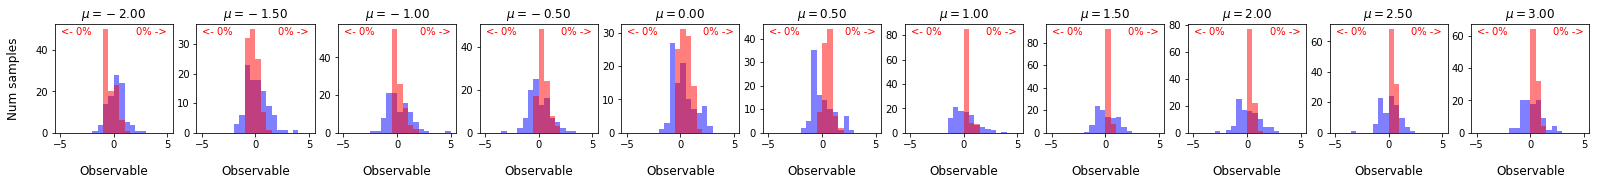

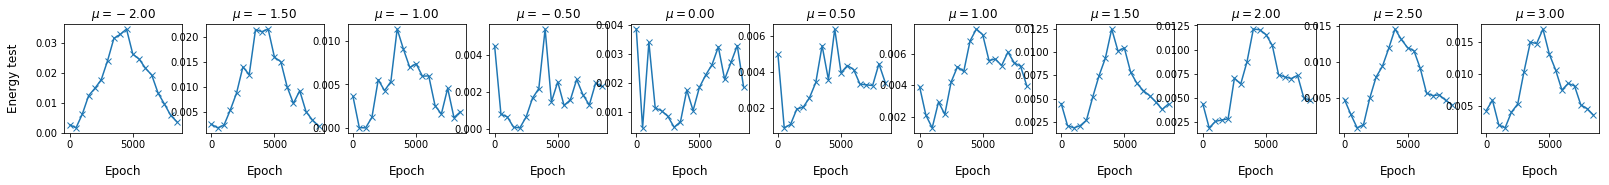

Epoch 9000 GAN loss is 0.06483301520347595
Batch size is 100
Energy test [mu = -2.00] = 0.00140, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00180, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00115, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00240, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00307, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00264, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00400, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00482, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00532, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00428, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00288, with threshold of 0.00076


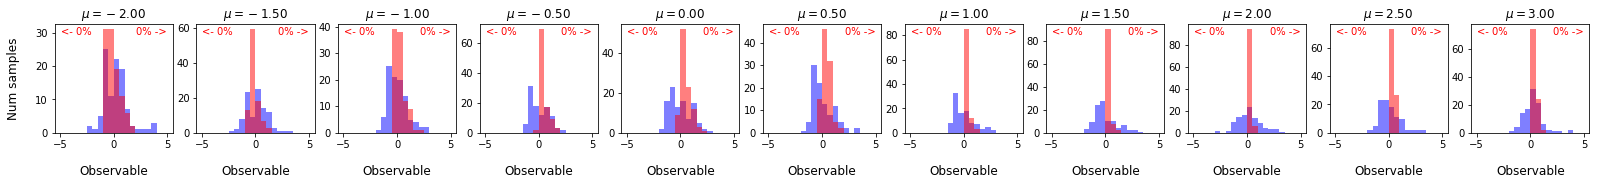

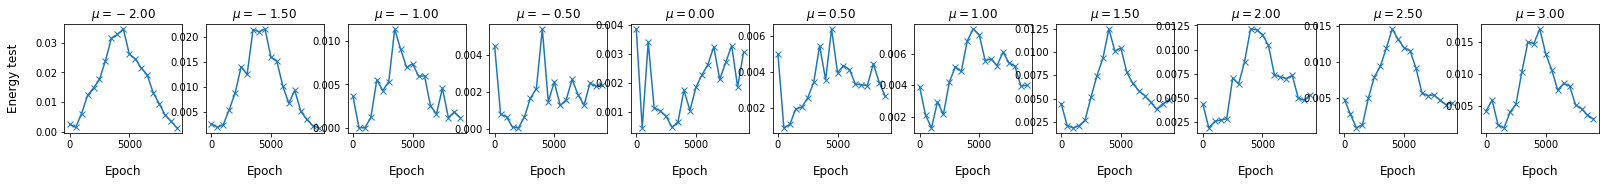

Epoch 9500 GAN loss is 0.06946573406457901
Batch size is 100
Energy test [mu = -2.00] = 0.00108, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00138, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00190, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00226, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00311, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00316, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00455, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00443, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00475, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00415, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00311, with threshold of 0.00076


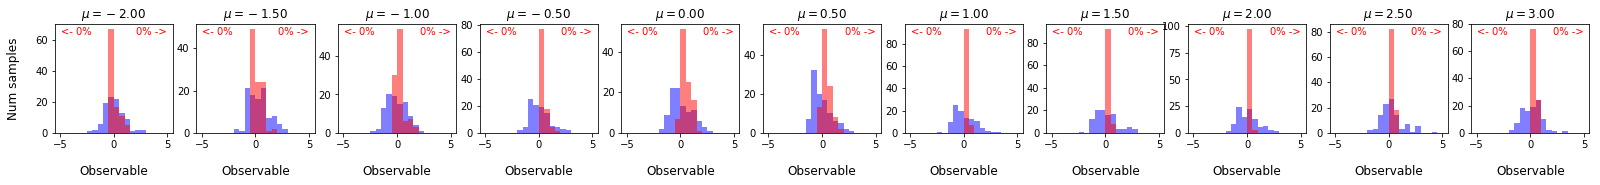

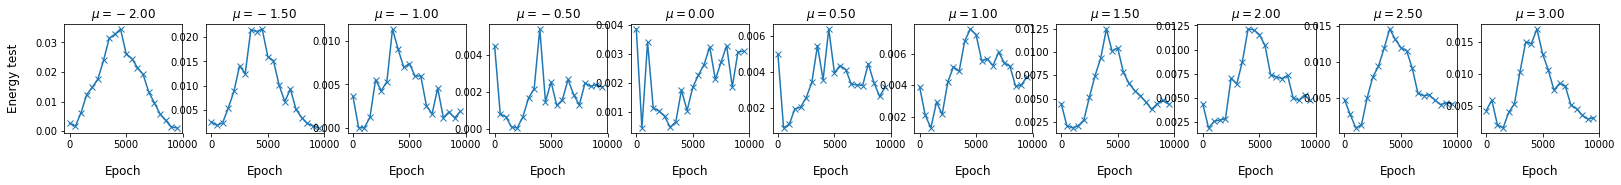

Epoch 10000 GAN loss is 0.012729613110423088
Batch size is 100
Energy test [mu = -2.00] = 0.00069, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00132, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00311, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00362, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00493, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00317, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00336, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00467, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00450, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00399, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00317, with threshold of 0.00076


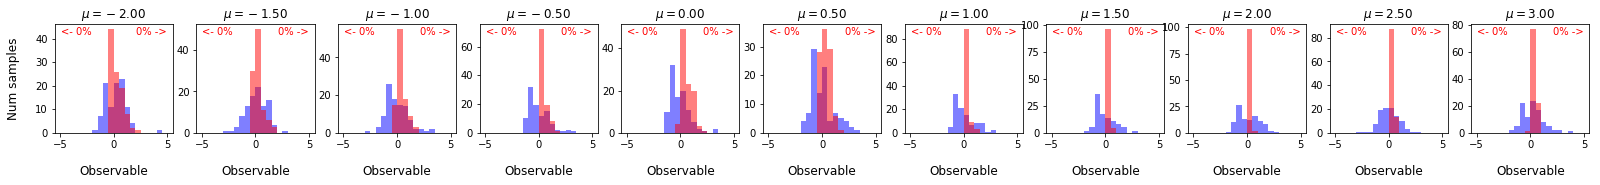

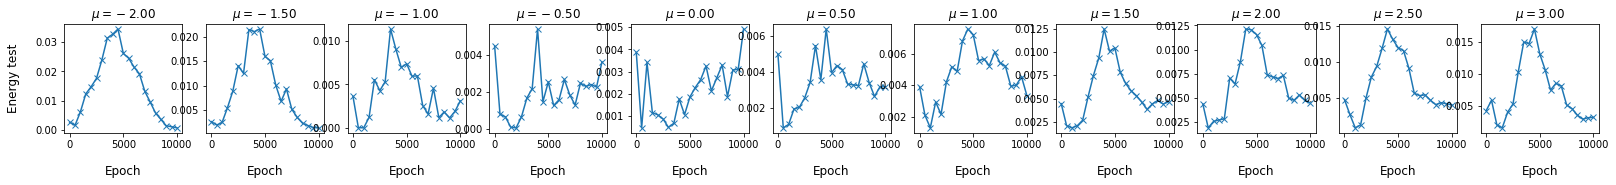

Epoch 10500 GAN loss is 0.032353442162275314
Batch size is 100
Energy test [mu = -2.00] = 0.00132, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00125, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00357, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00387, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00349, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00250, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00388, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00410, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00455, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00403, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00365, with threshold of 0.00076


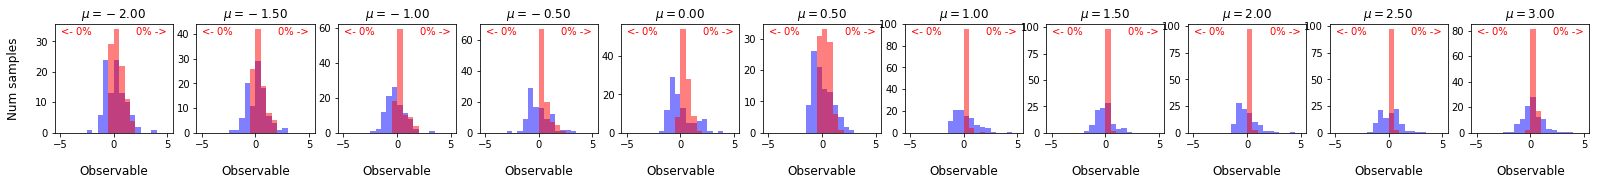

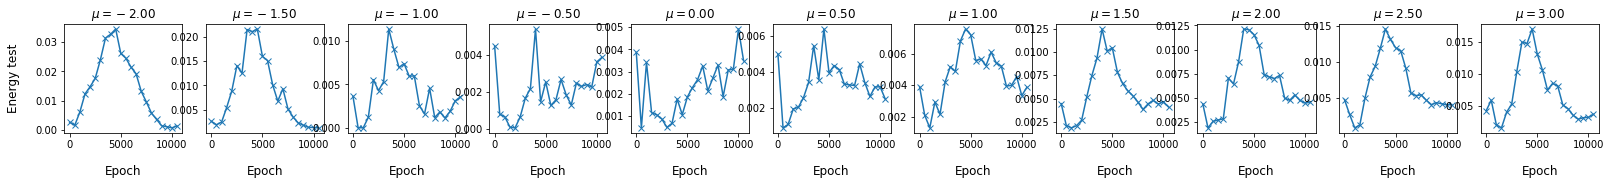

Epoch 11000 GAN loss is 0.0008581634610891342
Batch size is 100
Energy test [mu = -2.00] = 0.00166, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00208, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00242, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00278, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00529, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00218, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00386, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00475, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00540, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00396, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00392, with threshold of 0.00076


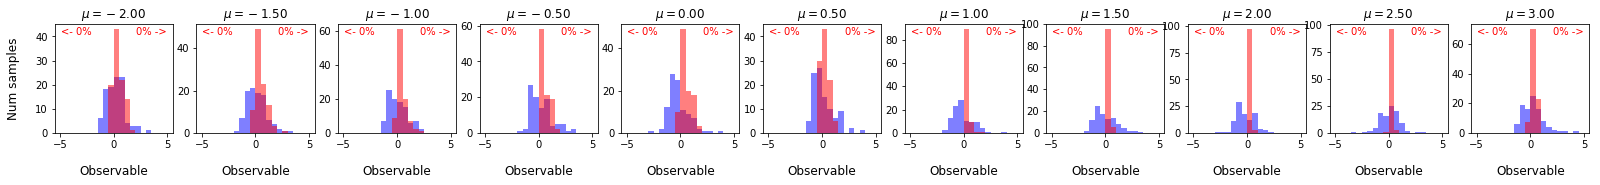

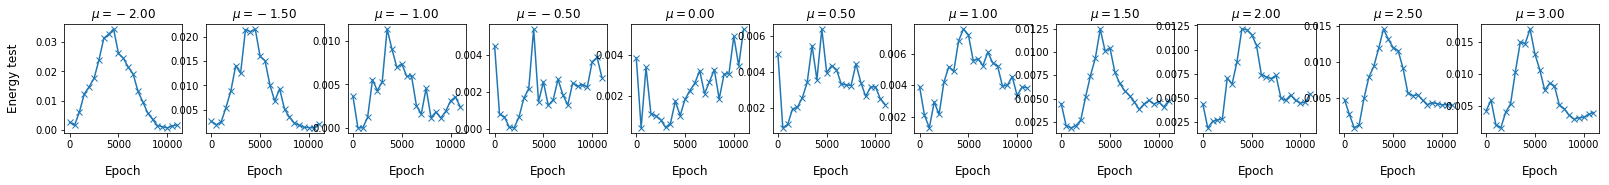

Epoch 11500 GAN loss is -0.011366523802280426
Batch size is 100
Energy test [mu = -2.00] = 0.00194, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00351, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00244, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00361, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00359, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00306, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00310, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00503, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00350, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00267, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00390, with threshold of 0.00076


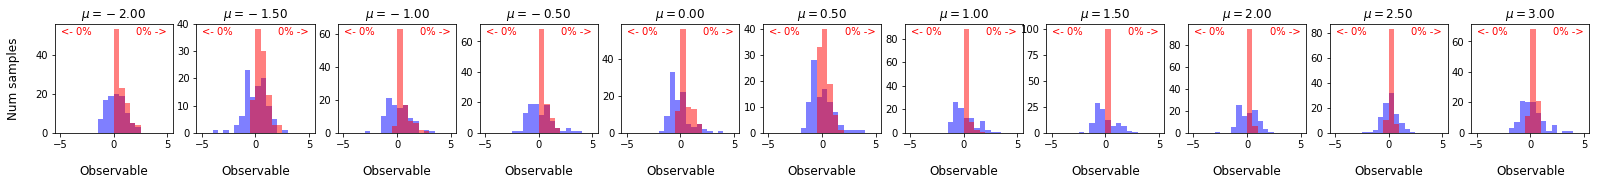

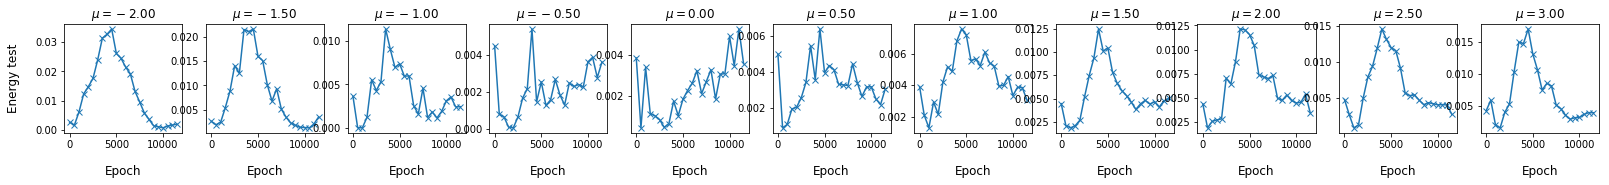

Epoch 12000 GAN loss is -0.04541397467255592
Batch size is 100
Energy test [mu = -2.00] = 0.00407, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00289, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00339, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00313, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00341, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00263, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00320, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00470, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00335, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00361, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00354, with threshold of 0.00076


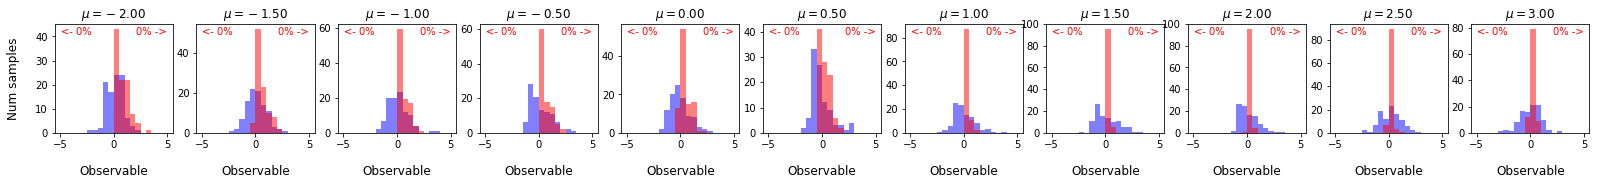

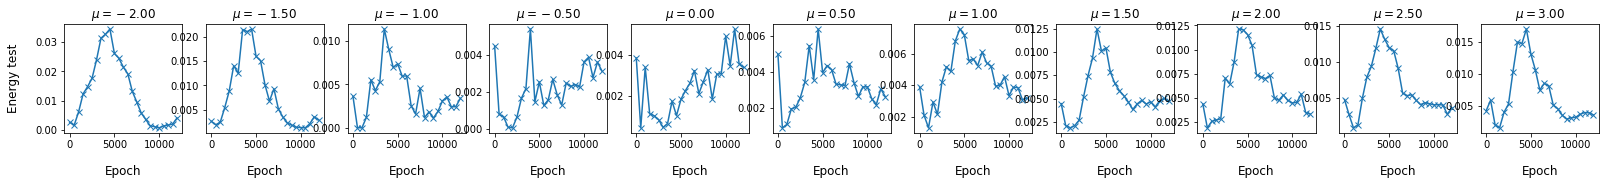

Epoch 12500 GAN loss is -0.0298878513276577
Batch size is 100
Energy test [mu = -2.00] = 0.00413, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00437, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00416, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00254, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00260, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00424, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00286, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00341, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00433, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00442, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00416, with threshold of 0.00076


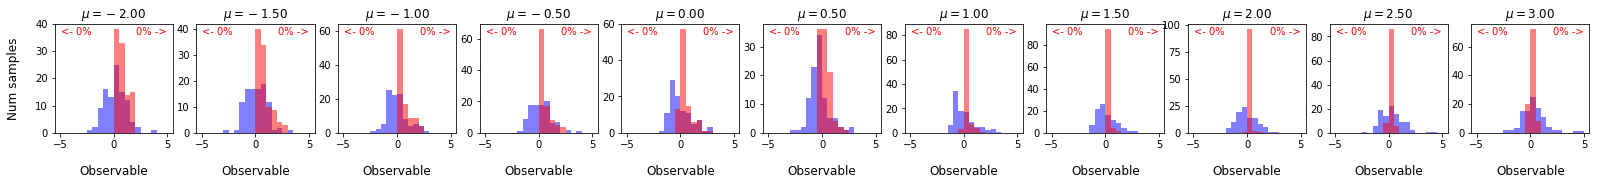

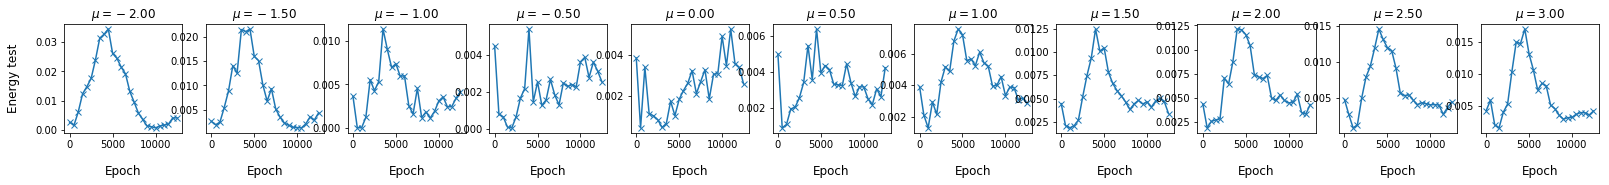

Epoch 13000 GAN loss is -0.08138083666563034
Batch size is 100
Energy test [mu = -2.00] = 0.00464, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00353, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00335, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00427, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00209, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00160, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00298, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00321, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00460, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00383, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00213, with threshold of 0.00076


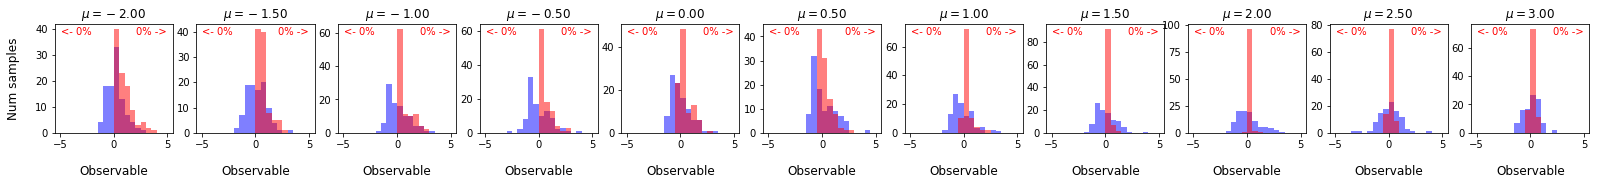

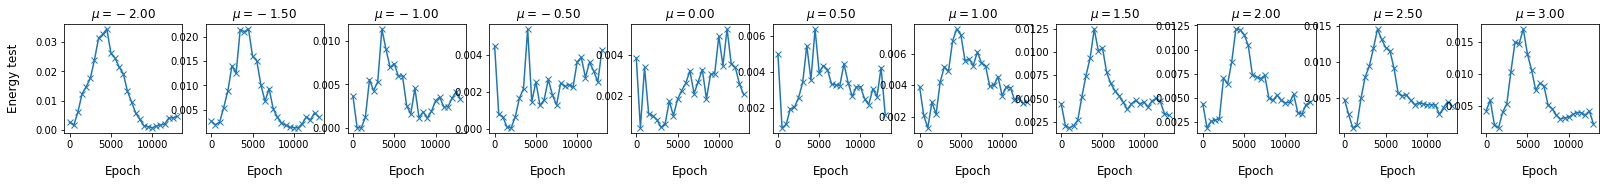

Epoch 13500 GAN loss is -0.1081133559346199
Batch size is 100
Energy test [mu = -2.00] = 0.00399, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00370, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00236, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00185, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00174, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00143, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00219, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00286, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00279, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00216, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00303, with threshold of 0.00076


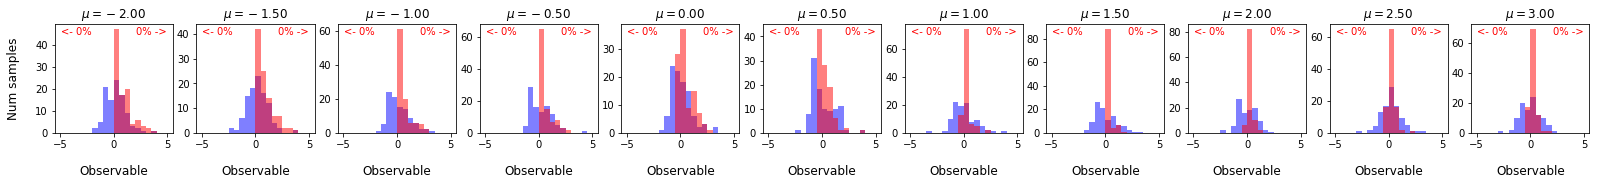

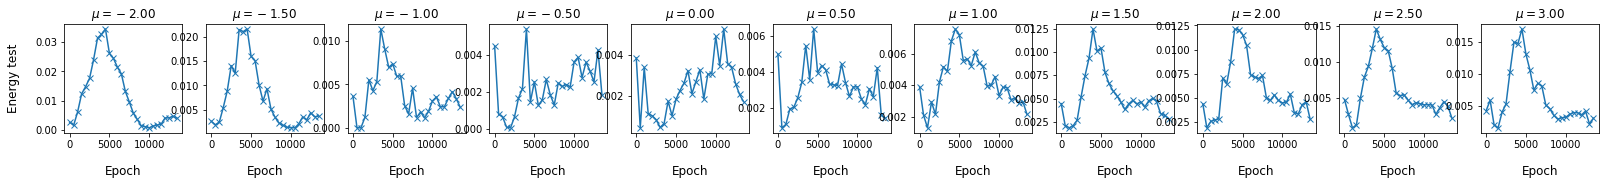

Epoch 14000 GAN loss is -0.12976449728012085
Batch size is 100
Energy test [mu = -2.00] = 0.00642, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00268, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00277, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00459, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00225, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00140, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00205, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00177, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00216, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00226, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00219, with threshold of 0.00076


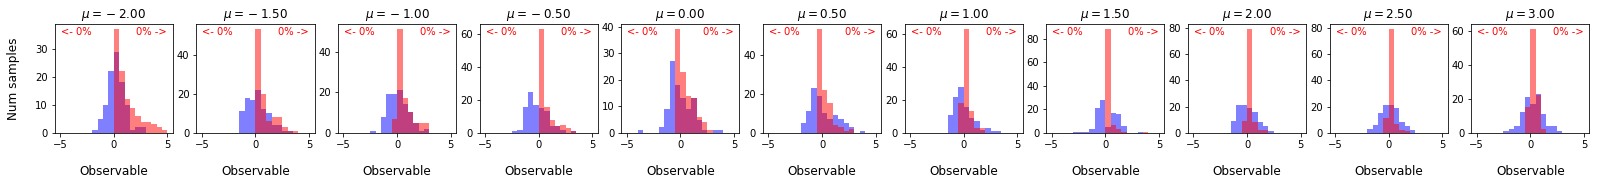

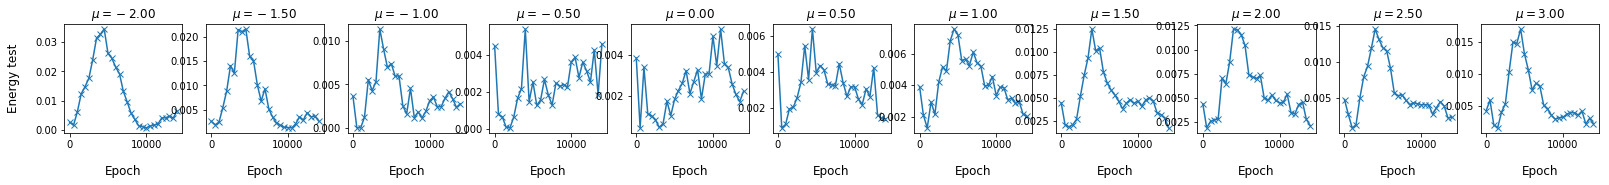

Epoch 14500 GAN loss is -0.15888403356075287
Batch size is 100
Energy test [mu = -2.00] = 0.00412, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00346, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00282, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00184, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00171, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00163, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00084, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00280, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00293, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00257, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00148, with threshold of 0.00076


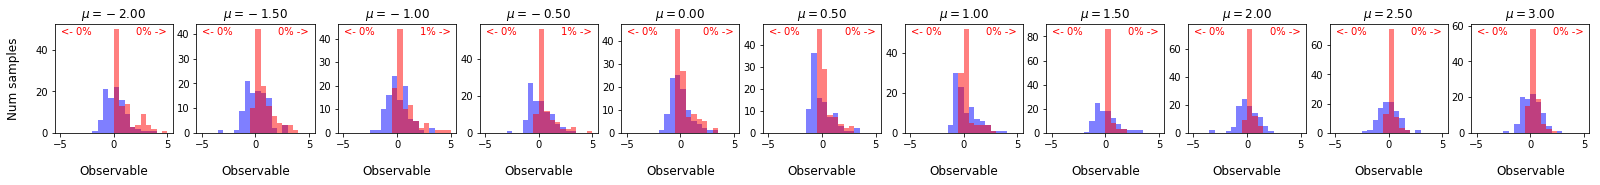

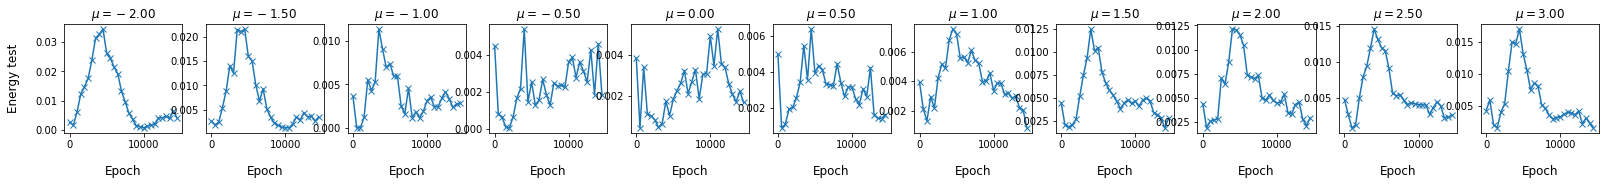

Epoch 15000 GAN loss is -0.17850443720817566
Batch size is 100
Energy test [mu = -2.00] = 0.00468, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00260, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00205, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00078, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00245, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00090, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00053, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00120, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00215, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00244, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00203, with threshold of 0.00076


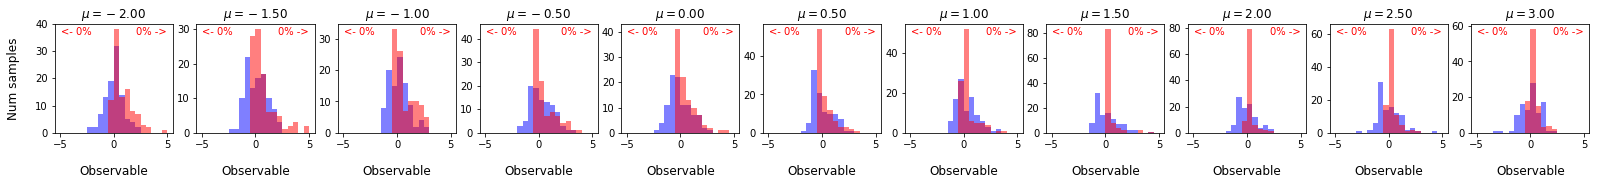

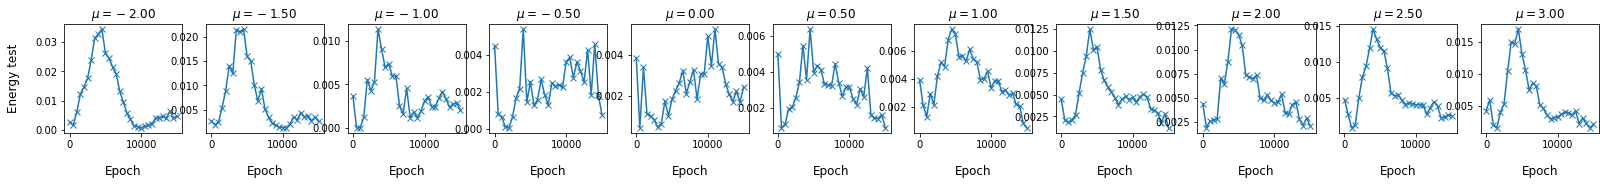

Epoch 15500 GAN loss is -0.23152171075344086
Batch size is 100
Energy test [mu = -2.00] = 0.00225, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00293, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00496, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00690, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00206, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00081, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00192, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00192, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00211, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00157, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00172, with threshold of 0.00076


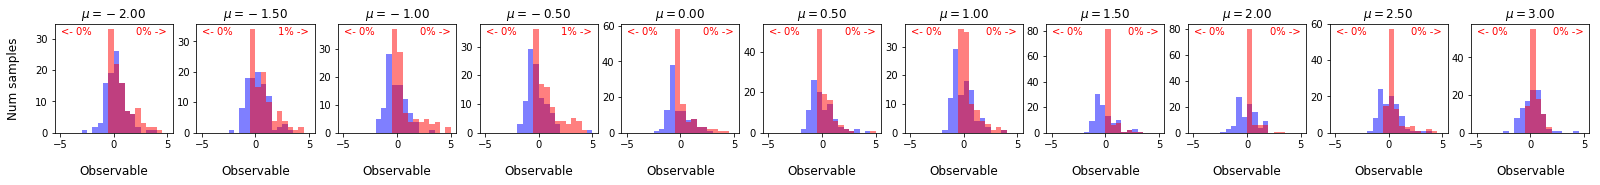

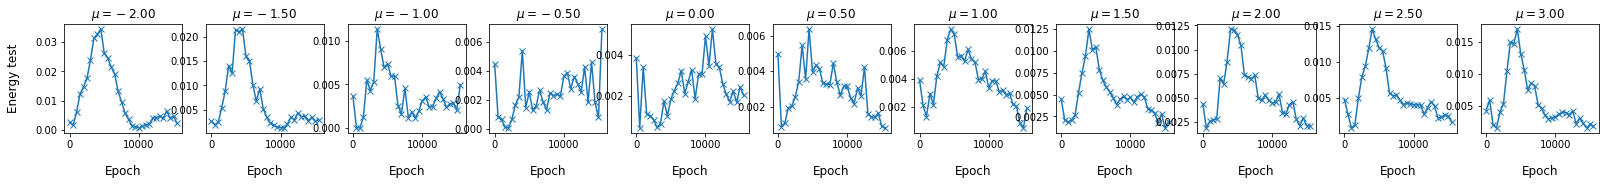

Epoch 16000 GAN loss is -0.24064671993255615
Batch size is 100
Energy test [mu = -2.00] = 0.00331, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00487, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00217, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00221, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00122, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00170, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00215, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00249, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00063, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00219, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00104, with threshold of 0.00076


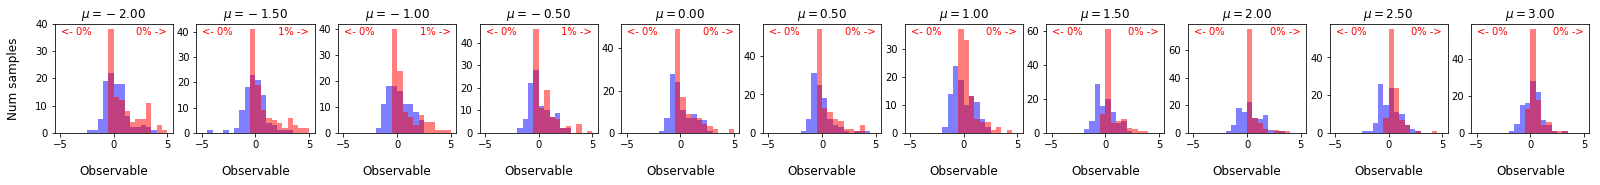

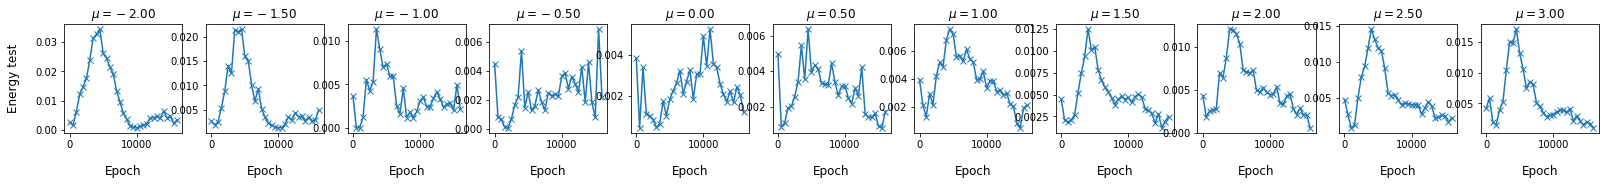

Epoch 16500 GAN loss is -0.24241627752780914
Batch size is 100
Energy test [mu = -2.00] = 0.00120, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00261, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00270, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00351, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00285, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00085, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00279, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00163, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00132, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00249, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00221, with threshold of 0.00076


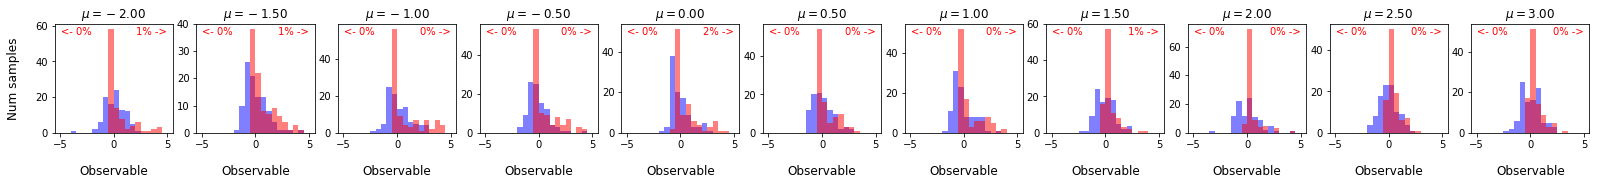

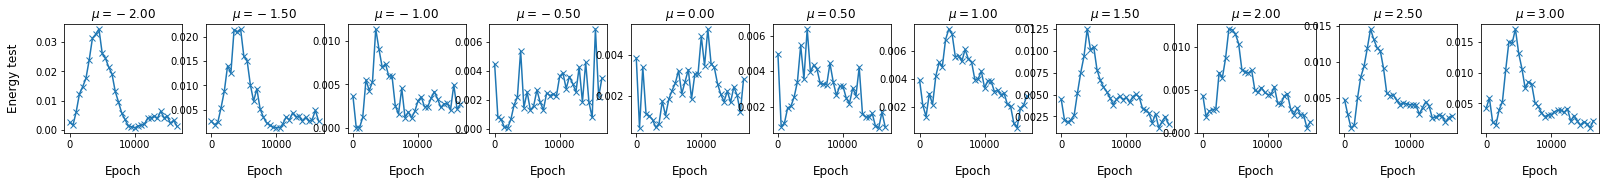

Epoch 17000 GAN loss is -0.2764892876148224
Batch size is 100
Energy test [mu = -2.00] = 0.00316, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00124, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00391, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00482, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00211, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00065, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00086, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00130, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00202, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00055, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00047, with threshold of 0.00076


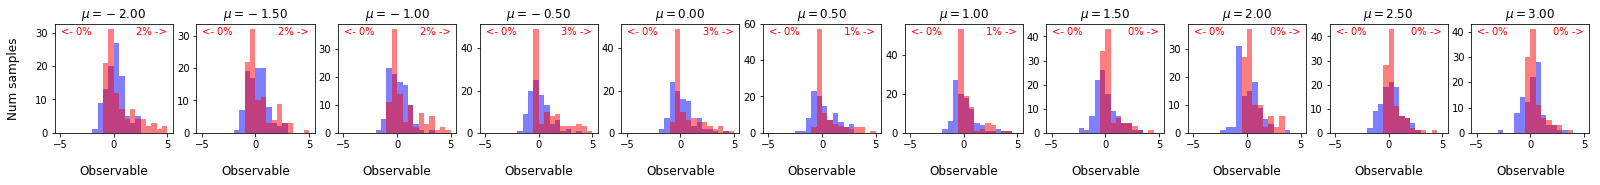

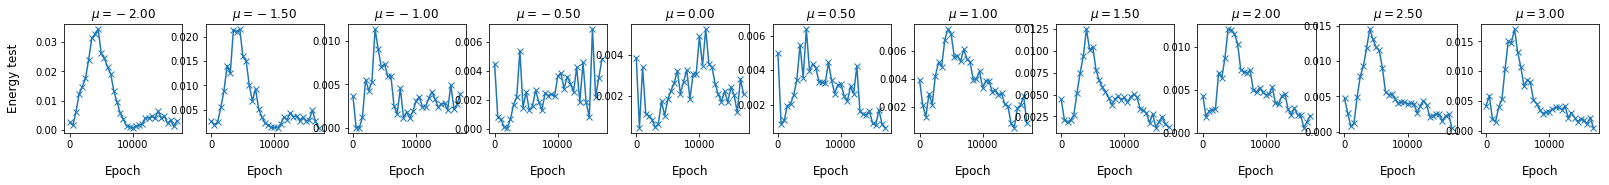

Epoch 17500 GAN loss is -0.3039127290248871
Batch size is 100
Energy test [mu = -2.00] = 0.00554, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00374, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00363, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00141, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00267, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00301, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00563, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00150, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00071, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00120, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00035, with threshold of 0.00076


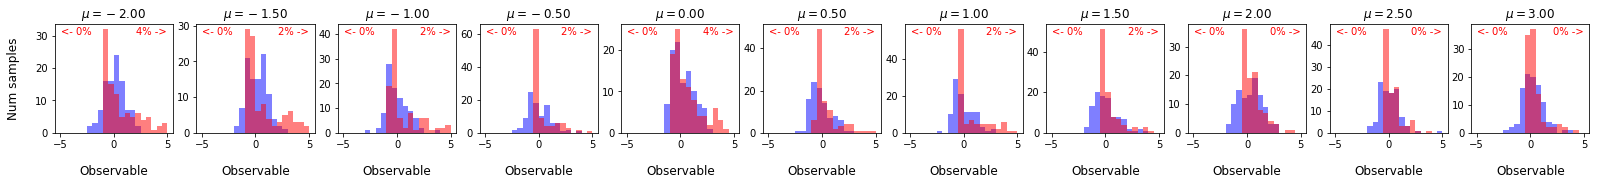

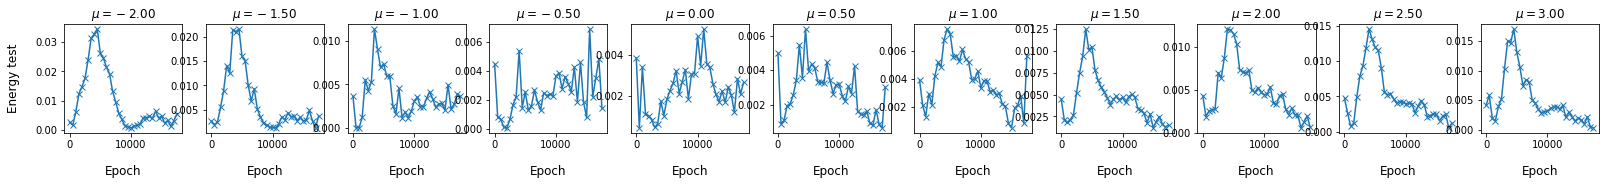

Epoch 18000 GAN loss is -0.34195297956466675
Batch size is 100
Energy test [mu = -2.00] = 0.00515, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00527, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00609, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00405, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00712, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00334, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00289, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00577, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00431, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00097, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00031, with threshold of 0.00076


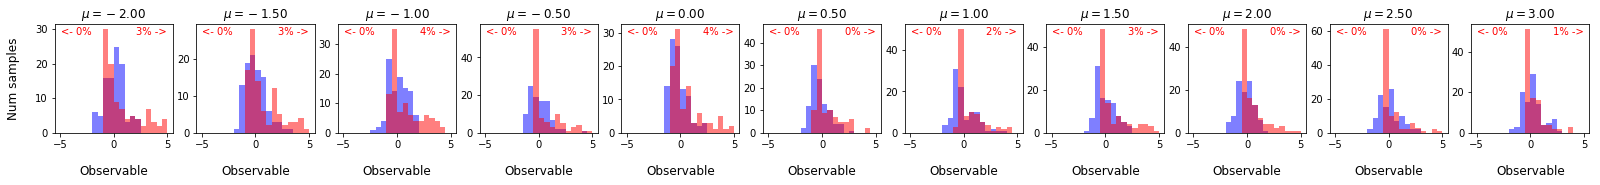

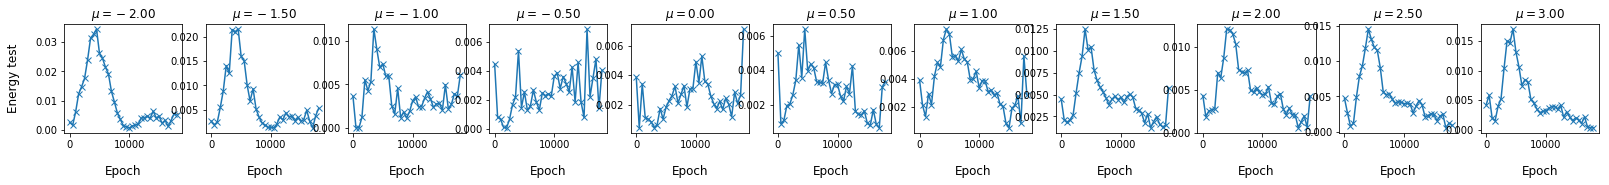

Epoch 18500 GAN loss is -0.3319067060947418
Batch size is 100
Energy test [mu = -2.00] = 0.00659, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00698, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00242, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00355, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00488, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00345, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00118, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00158, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00226, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00079, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00155, with threshold of 0.00076


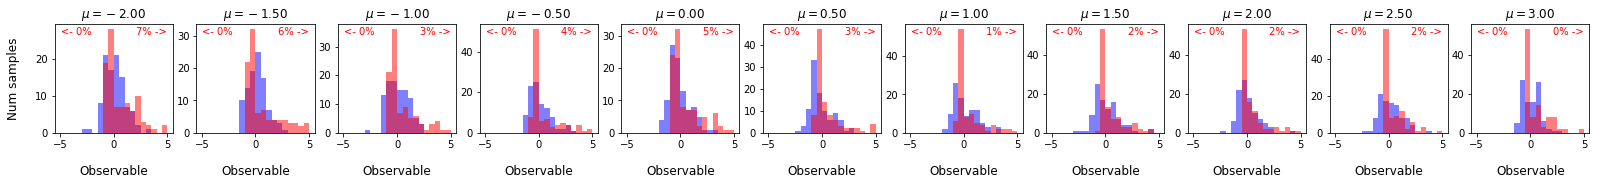

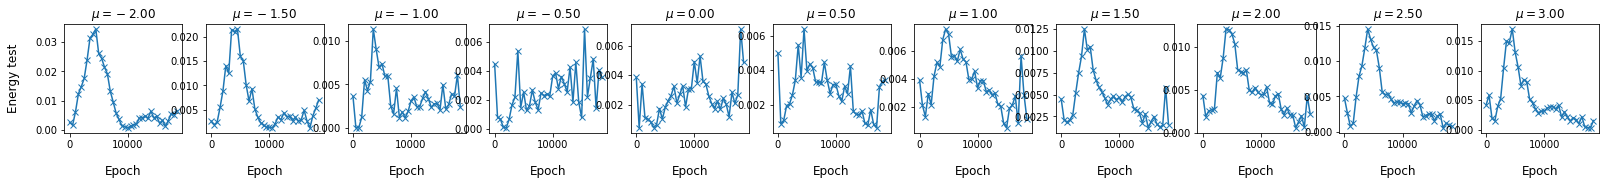

Epoch 19000 GAN loss is -0.3210526406764984
Batch size is 100
Energy test [mu = -2.00] = 0.00549, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00672, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00450, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00852, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00382, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00210, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00437, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00235, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00278, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00072, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00039, with threshold of 0.00076


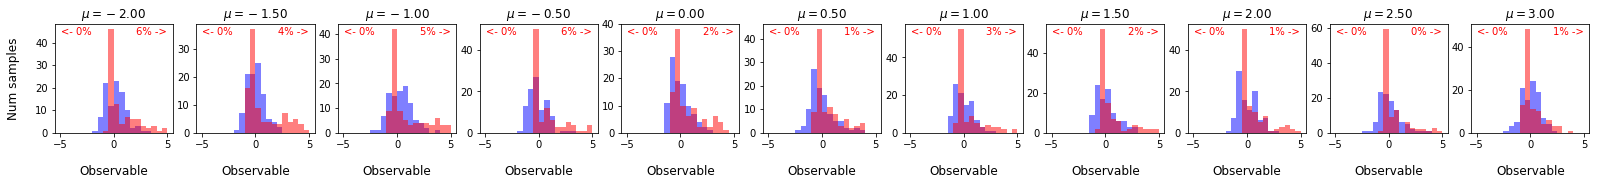

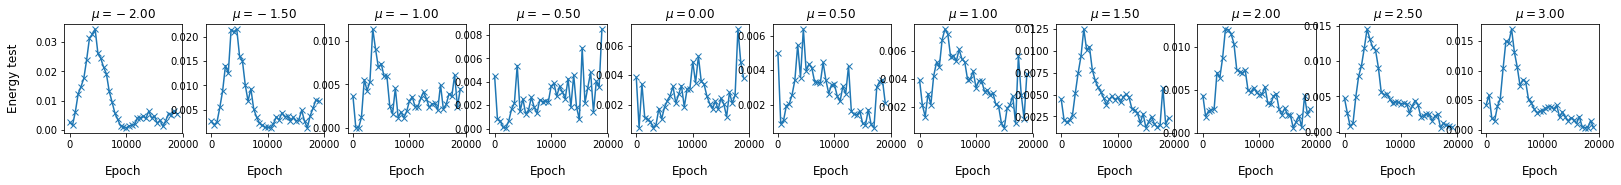

Epoch 19500 GAN loss is -0.3209277391433716
Batch size is 100
Energy test [mu = -2.00] = 0.01166, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00937, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00298, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00575, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00279, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00403, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00428, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00341, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00433, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00246, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00043, with threshold of 0.00076


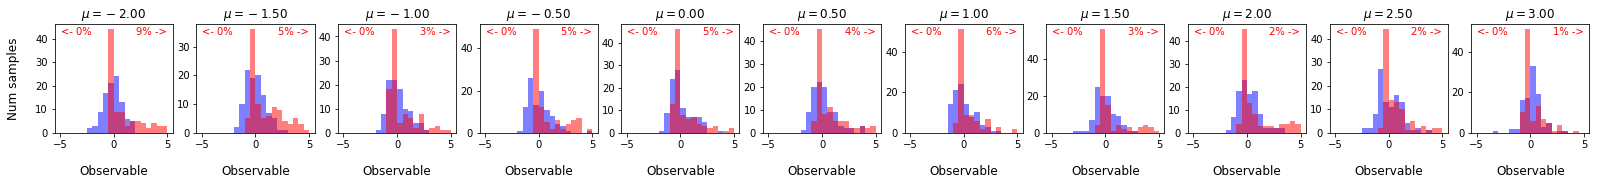

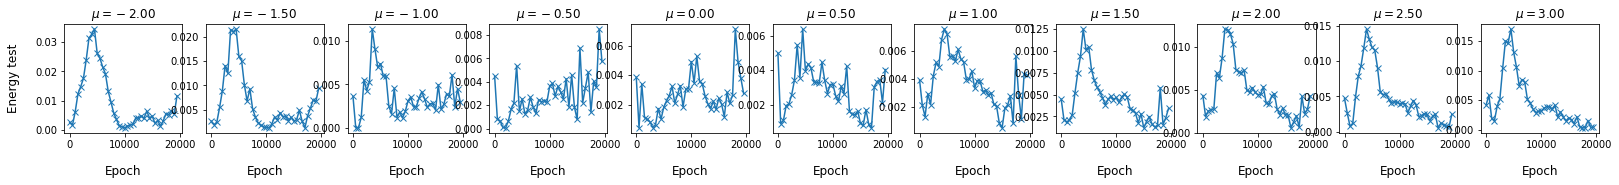

Epoch 20000 GAN loss is -0.3565816283226013
Batch size is 100
Energy test [mu = -2.00] = 0.00658, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00377, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00483, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00645, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00062, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00488, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00647, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00291, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00038, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00174, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00139, with threshold of 0.00076


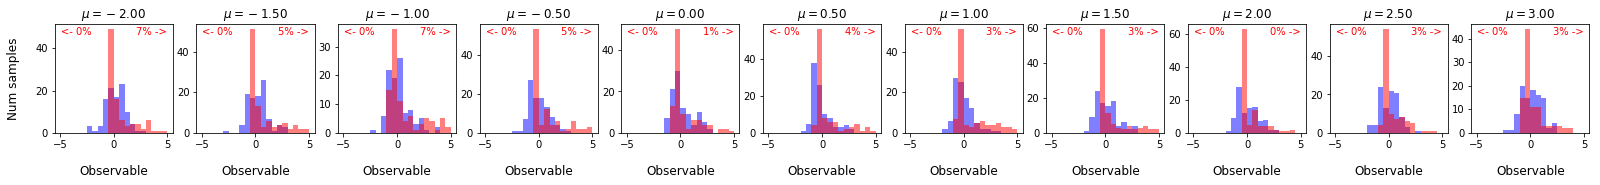

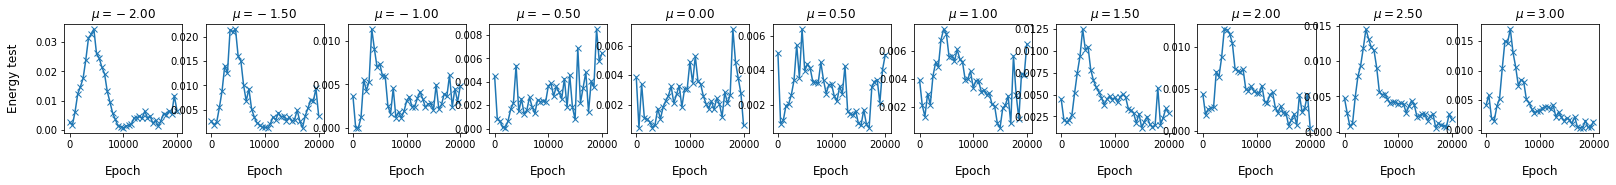

Epoch 20500 GAN loss is -0.35075750946998596
Batch size is 100
Energy test [mu = -2.00] = 0.01611, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00833, with threshold of 0.00111
Energy test [mu = -1.00] = 0.01103, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00598, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00321, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00576, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00560, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00384, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00194, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00207, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00321, with threshold of 0.00076


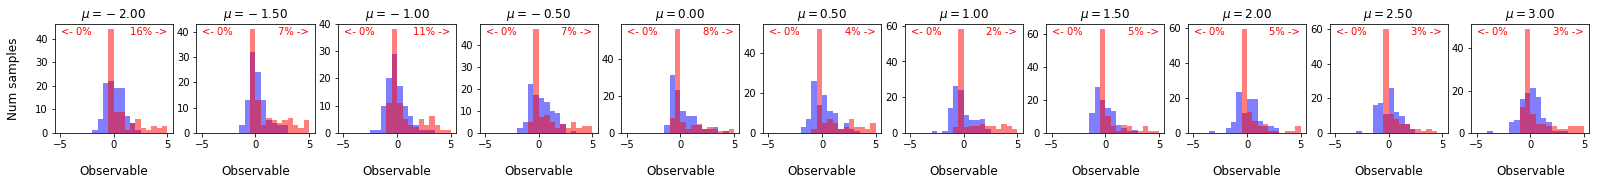

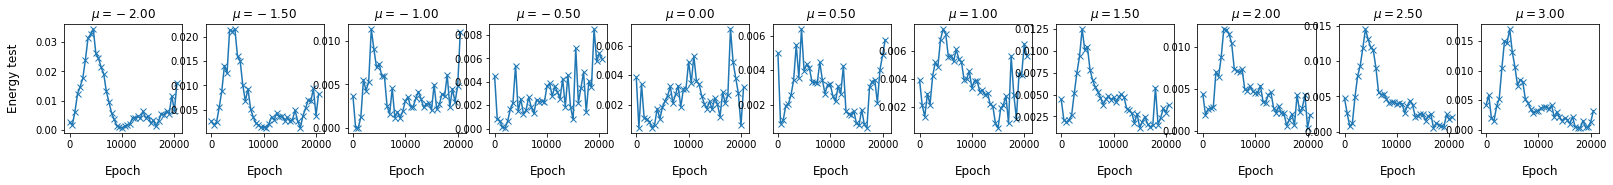

Epoch 21000 GAN loss is -0.3721466362476349
Batch size is 100
Energy test [mu = -2.00] = 0.01446, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00667, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00907, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00728, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00558, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00437, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00812, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00571, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00071, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00459, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00132, with threshold of 0.00076


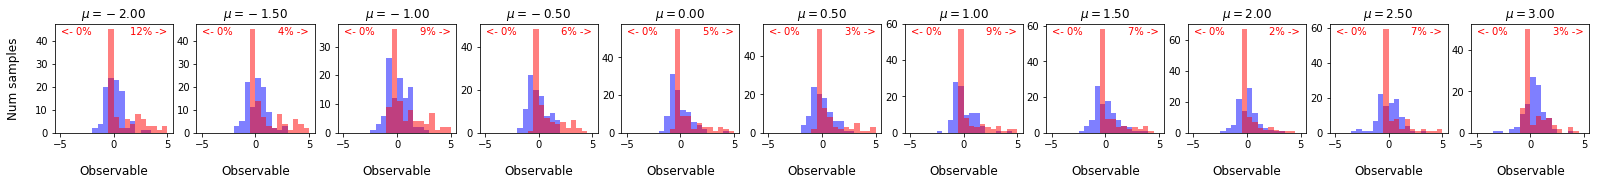

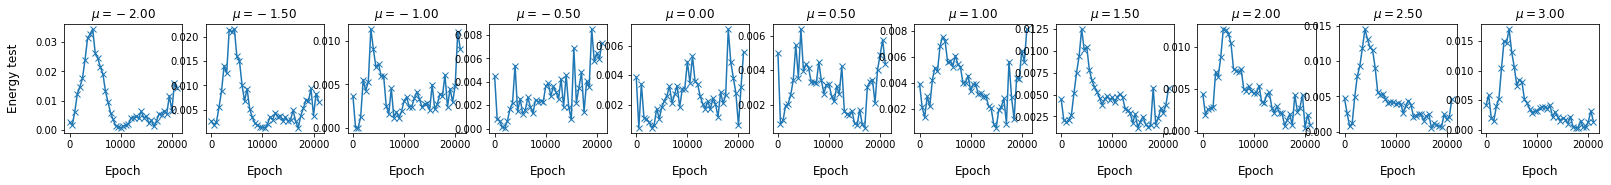

Epoch 21500 GAN loss is -0.39028820395469666
Batch size is 100
Energy test [mu = -2.00] = 0.00600, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00906, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00636, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00497, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00310, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00303, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00310, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00300, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00412, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00280, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00177, with threshold of 0.00076


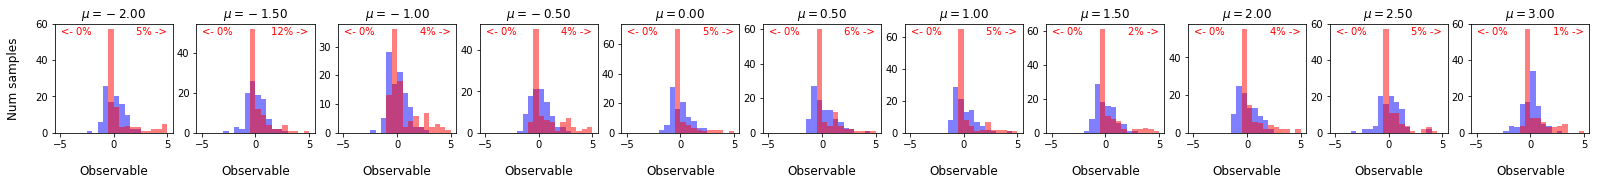

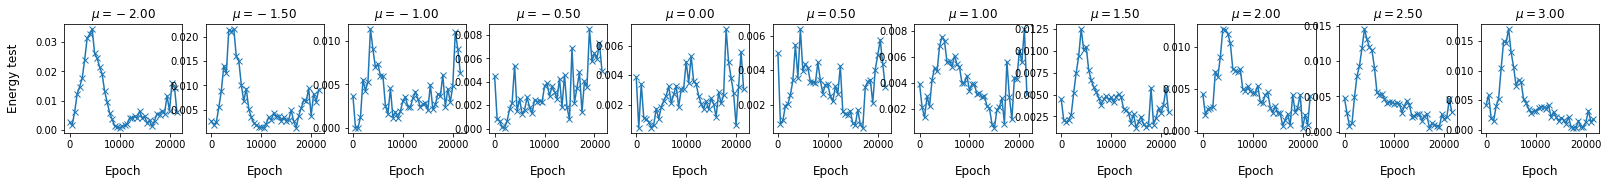

Epoch 22000 GAN loss is -0.37167859077453613
Batch size is 100
Energy test [mu = -2.00] = 0.01342, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00921, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00630, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00615, with threshold of 0.00070
Energy test [mu = 0.00] = 0.01100, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00422, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00141, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00468, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00183, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00245, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00189, with threshold of 0.00076


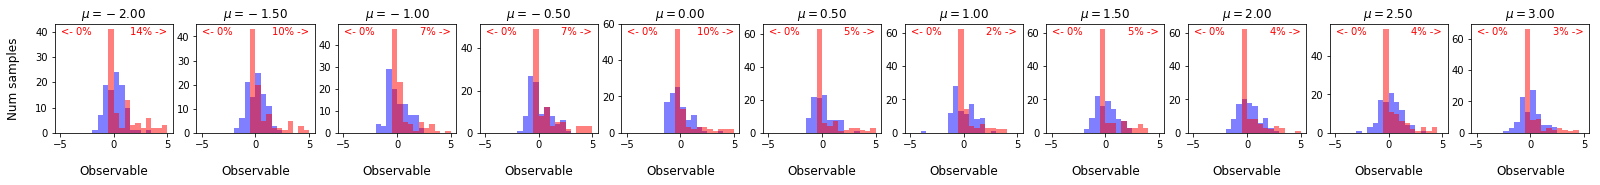

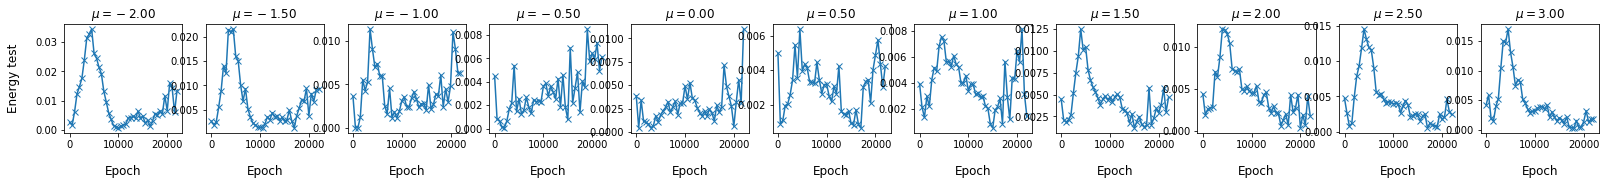

Epoch 22500 GAN loss is -0.3871888816356659
Batch size is 100
Energy test [mu = -2.00] = 0.00682, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01277, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00934, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00981, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00335, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00688, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00391, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00084, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00657, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00411, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00213, with threshold of 0.00076


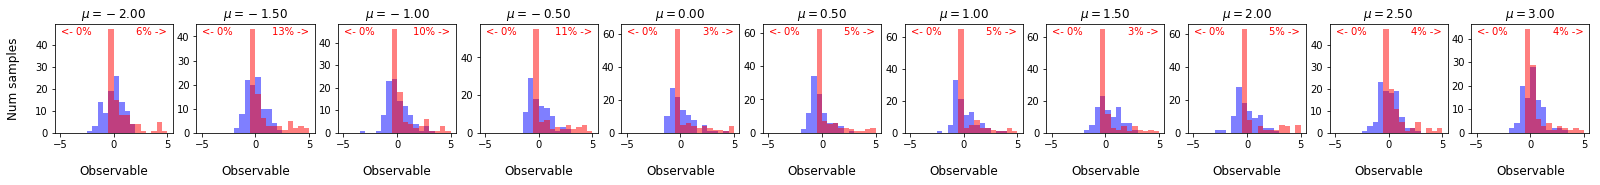

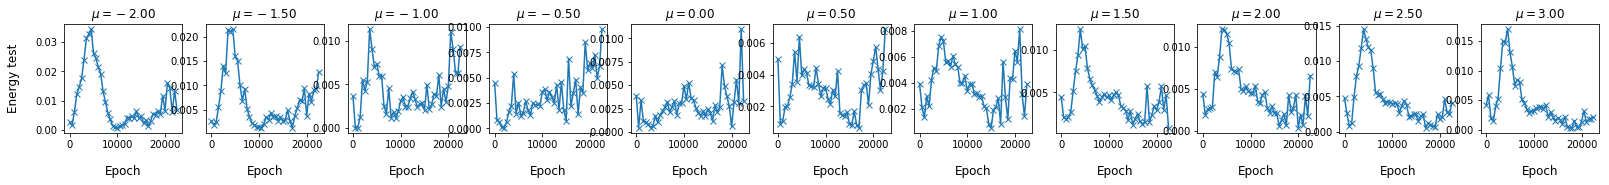

Epoch 23000 GAN loss is -0.35058870911598206
Batch size is 100
Energy test [mu = -2.00] = 0.01028, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01062, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00882, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00807, with threshold of 0.00070
Energy test [mu = 0.00] = 0.01156, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00457, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00580, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00214, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00540, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00200, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00294, with threshold of 0.00076


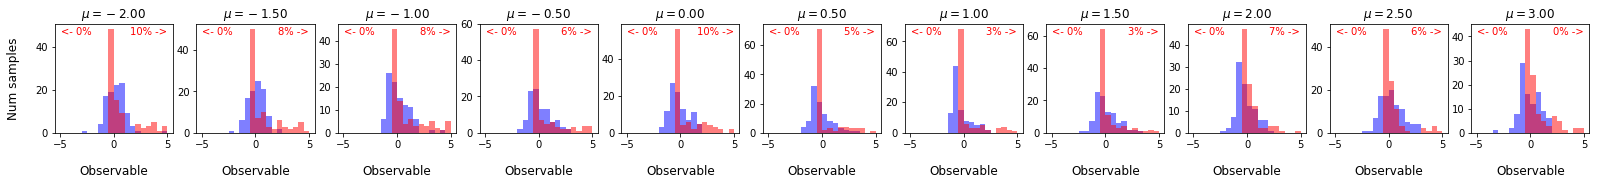

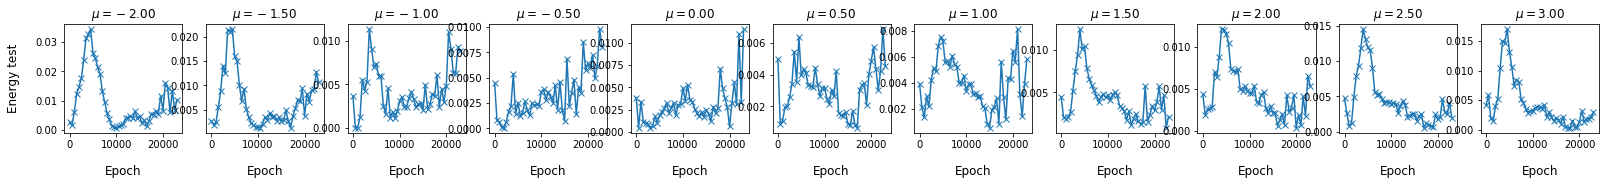

Epoch 23500 GAN loss is -0.4000271260738373
Batch size is 100
Energy test [mu = -2.00] = 0.01301, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00729, with threshold of 0.00111
Energy test [mu = -1.00] = 0.01047, with threshold of 0.00044
Energy test [mu = -0.50] = 0.01242, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00462, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00472, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00602, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00577, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00664, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00334, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00124, with threshold of 0.00076


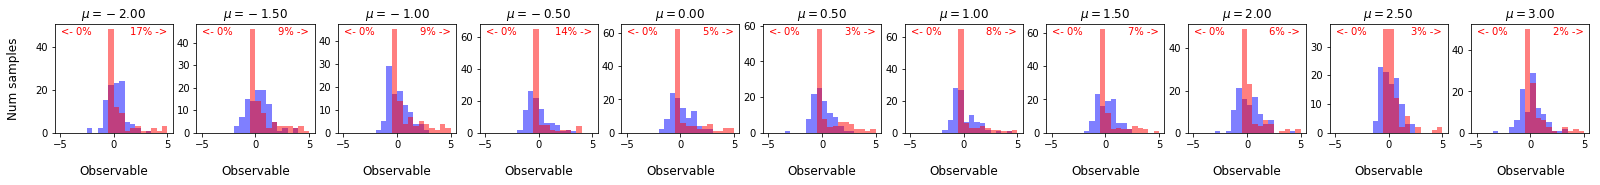

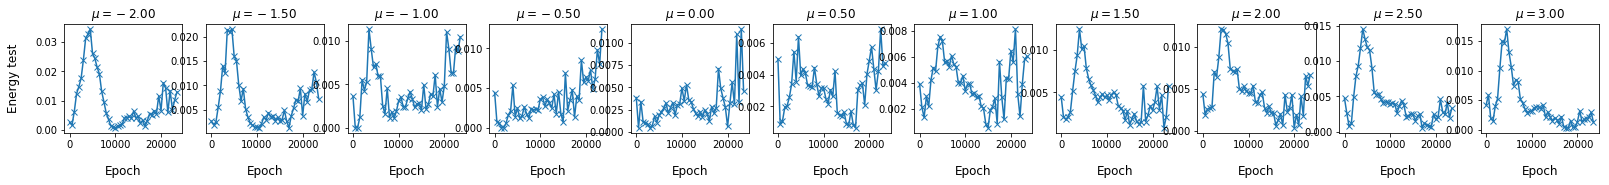

Epoch 24000 GAN loss is -0.39551842212677
Batch size is 100
Energy test [mu = -2.00] = 0.01332, with threshold of 0.00036
Energy test [mu = -1.50] = 0.00908, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00989, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00914, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00777, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00758, with threshold of 0.00081
Energy test [mu = 1.00] = 0.00770, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00303, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00232, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00414, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00386, with threshold of 0.00076


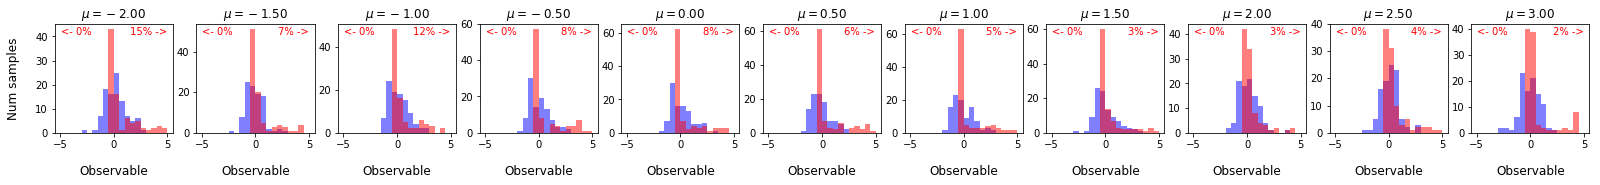

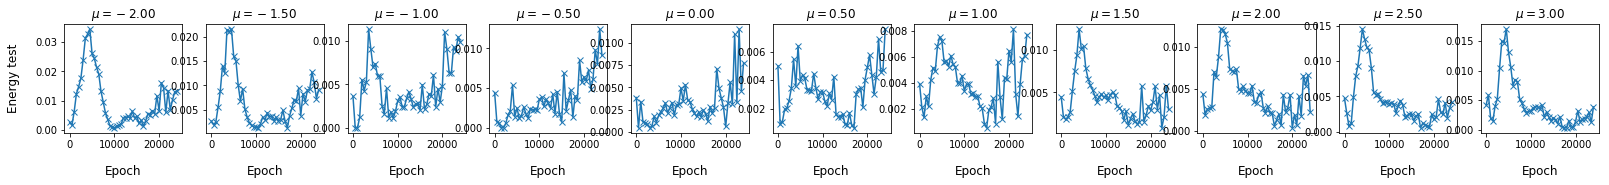

Epoch 24500 GAN loss is -0.38766372203826904
Batch size is 100
Energy test [mu = -2.00] = 0.01275, with threshold of 0.00036
Energy test [mu = -1.50] = 0.01617, with threshold of 0.00111
Energy test [mu = -1.00] = 0.00985, with threshold of 0.00044
Energy test [mu = -0.50] = 0.00724, with threshold of 0.00070
Energy test [mu = 0.00] = 0.00510, with threshold of 0.00100
Energy test [mu = 0.50] = 0.00483, with threshold of 0.00081
Energy test [mu = 1.00] = 0.01206, with threshold of 0.00128
Energy test [mu = 1.50] = 0.00223, with threshold of 0.00175
Energy test [mu = 2.00] = 0.00292, with threshold of 0.00070
Energy test [mu = 2.50] = 0.00110, with threshold of 0.00145
Energy test [mu = 3.00] = 0.00168, with threshold of 0.00076


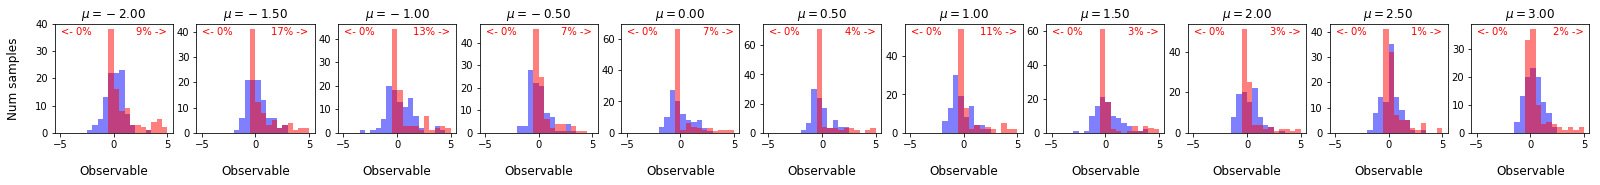

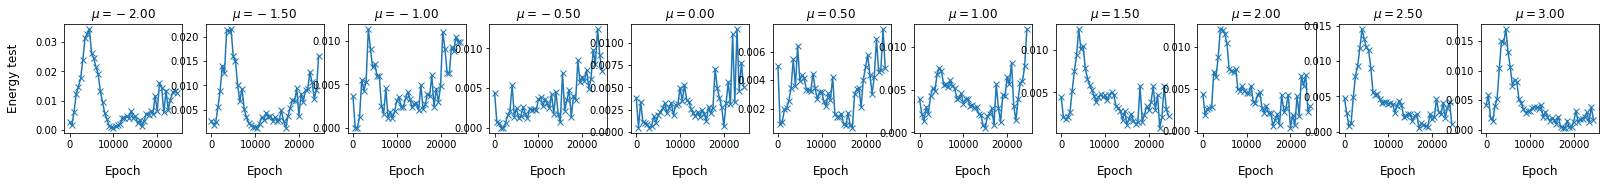

KeyboardInterrupt: 

In [20]:
generator, critic, GAN = layer_generators[0], layer_critics[0], layer_GANs[0]

epoch_idx = -1
axis_idx  = 0
batch_size = initial_batch_size
print("Getting initial Et thresholds")
Et_thresholds = get_Et_thresholds(batch_size, threshold=energy_test_threshold, num_toys=energy_test_ntoys)
saved_epochs, saved_energy_tests, epoch_batch_size_transitions = [], {}, []
while epoch_idx < max_epochs :
    epoch_idx = epoch_idx + 1
    
    num_conditions = len(mu_scan_points)
    data_batch , data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=axis_idx+1)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, mu_scan_points, axis_idx+1, generator)
    data_labels = np.array([1  for i in range(num_conditions*batch_size)])
    fake_labels = np.array([-1 for i in range(num_conditions*batch_size)])
    
    critic_train_X_datapoints = [data_batch     , fakes_batch     ]
    critic_train_X_conditions = [data_conditions, fakes_conditions]
    critic_train_Y_labels     = [data_labels    , fake_labels     ]
    
    generated_sample_weight = 1.
    if type(add_generator_noise) != type(None) :
        gen_noise, gen_noise_conditions = get_generator_noise_samples (batch_size, mu_scan_points, axis_idx+1, add_generator_noise)
        gen_noise_labels = np.array([-1 for i in range(len(gen_noise))])
        critic_train_X_datapoints.append(gen_noise           )
        critic_train_X_conditions.append(gen_noise_conditions)
        critic_train_Y_labels    .append(gen_noise_labels    )
        generated_sample_weight = 1. / (1. + add_generator_noise[2])
    
    critic_train_X_datapoints = np.concatenate(critic_train_X_datapoints)
    critic_train_X_conditions = np.concatenate(critic_train_X_conditions)
    critic_train_Y_labels     = np.concatenate(critic_train_Y_labels    )
    critic_train_Y_weights    = []
    for x in critic_train_Y_labels :
        if x == 1 : critic_train_Y_weights.append(1.)
        else      : critic_train_Y_weights.append(generated_sample_weight)
    critic_train_Y_weights = np.array(critic_train_Y_weights)
    critic_train_X_datapoints, critic_train_X_conditions, critic_train_Y_labels, critic_train_Y_weights = joint_shuffle(critic_train_X_datapoints, critic_train_X_conditions, critic_train_Y_labels, critic_train_Y_weights)
    
    if update_critic_fixed_ntimes :
        critic_train_X = [critic_train_X_datapoints, critic_train_X_conditions]        
    else :
        val_split_idx = int(0.7*len(critic_train_X_datapoints))
        critic_val_X_datapoints  , critic_val_X_conditions  , critic_val_Y_labels  , critic_val_Y_weights   = critic_train_X_datapoints[val_split_idx:], critic_train_X_conditions[val_split_idx:], critic_train_Y_labels[val_split_idx:], critic_train_Y_weights[val_split_idx:]
        critic_train_X_datapoints, critic_train_X_conditions, critic_train_Y_labels, critic_train_Y_weights = critic_train_X_datapoints[:val_split_idx], critic_train_X_conditions[:val_split_idx], critic_train_Y_labels[:val_split_idx], critic_train_Y_weights[:val_split_idx]
        critic_train_X = [critic_train_X_datapoints, critic_train_X_conditions]
        critic_val_X   = [critic_val_X_datapoints  , critic_val_X_conditions  ]
    
    # train critic
    #print(f"Training critic at epoch {epoch_idx}")
    critic.trainable = True
    
    if update_critic_fixed_ntimes :
        for i in range(max_critic_updates_per_epoch) :
            critic.train_on_batch(critic_train_X, -1.*critic_train_Y_labels, sample_weight=critic_train_Y_weights)
    
    else :
        critic_train_idx, iterate_critic, critic_val_loss = 0, True, 1e30
        while iterate_critic :
            critic.train_on_batch(critic_train_X, -1.*critic_train_Y_labels, sample_weight=critic_train_Y_weights)
            new_critic_val_loss = critic.evaluate(critic_val_X, -1.*critic_val_Y_labels, sample_weight=critic_val_Y_weights, verbose=0)
            critic_train_idx = critic_train_idx + 1
            if new_critic_val_loss < critic_val_loss : critic_val_loss = new_critic_val_loss
            else : iterate_critic = False
            if critic_train_idx < max_critic_updates_per_epoch : continue
            iterate_critic = False
        
    '''critic.fit(critic_train_X, 
               -1.*critic_train_Y_labels,
               shuffle=True,
               validation_split=0.3,
               epochs=max_critic_updates_per_epoch,
               callbacks=[EarlyStopping(restore_best_weights=True, 
                                        monitor="val_loss", 
                                        patience=3)]
               )'''
    
    # train generator
    #print(f"Training generator at epoch {epoch_idx}")
    new_noise, new_conditions = get_noise (batch_size, mu_scan_points, axis_idx+1)
    generator_train_X = [new_noise, new_conditions]
    critic   .trainable = False
    generator.trainable = True
    for i in range(max_critic_updates_per_epoch) :
        GAN_loss = GAN.train_on_batch(generator_train_X, fake_labels)
    '''GAN.fit(generator_train_X, 
            fake_labels,
            shuffle=True,
            validation_split=0.3,
            epochs=max_gen_updates_per_epoch,
            callbacks=[EarlyStopping(restore_best_weights=True, 
                                     monitor="val_loss", 
                                     patience=3)]
               )
    GAN_loss = GAN.evaluate(generator_train_X, fake_labels)'''
    if epoch_idx % epoch_print_interval != 0 : continue
    print(f"Epoch {epoch_idx} GAN loss is {GAN_loss}")
    print(f"Batch size is {batch_size}")
    
    data_batch , data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=axis_idx+1)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, mu_scan_points, axis_idx+1, generator)
    
    num_mu_scan_points = len(mu_scan_points)
    fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
    ax_lims = axis_lims[0]
    update_batch_size = True if batch_size < max_batch_size else False
    saved_epochs.append(epoch_idx+1)
    for ax_idx, mu in enumerate(mu_scan_points) :
        ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
        plot_data  = np.array([x for x,c in zip(data_batch , data_conditions ) if c == mu])
        plot_data .reshape((plot_data.shape[0],))
        plot_fakes = np.array([x for x,c in zip(fakes_batch, fakes_conditions) if c == mu])
        plot_fakes.reshape((plot_fakes.shape[0],))
        #ax.hist(plot_data , color="blue", alpha=0.5)
        #ax.hist(plot_fakes, color="red" , alpha=0.5)
        ax.hist(plot_data , bins=np.linspace(ax_lims[0], ax_lims[1], 21), color="blue", alpha=0.5)
        ax.hist(plot_fakes, bins=np.linspace(ax_lims[0], ax_lims[1], 21), color="red" , alpha=0.5)
        ax.text(0.95, 0.9, f"{100.*len([x for x in plot_fakes if x > ax_lims[1]])/len(plot_data):.0f}% ->", ha="right", color="red", transform=ax.transAxes)
        ax.text(0.05, 0.9, f"<- {100.*len([x for x in plot_fakes if x < ax_lims[0]])/len(plot_data):.0f}%", ha="left" , color="red", transform=ax.transAxes)
        ax.set_xlabel("Observable", fontsize=12, labelpad=15)
        if ax_idx == 0 : ax.set_ylabel("Num samples", fontsize=12, labelpad=15)
        ax.set_title(f"$\mu = {mu:.2f}$")
        Et           = energy_test_stat(plot_data, plot_fakes)
        Et_threshold = Et_thresholds [mu]
        print(f"Energy test [mu = {mu:.2f}] = {Et:.5f}, with threshold of {Et_threshold:.5f}")
        if Et > Et_threshold : update_batch_size = False
        if mu not in saved_energy_tests : saved_energy_tests [mu] = []
        saved_energy_tests[mu].append(Et)
    plt.show()
    
    fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
    for ax_idx, mu in enumerate(mu_scan_points) :
        ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
        ax.plot(saved_epochs, saved_energy_tests[mu], "x-")
        for v in epoch_batch_size_transitions :
            ax.axvline(v[0], color="gray", linestyle="--", linewidth=1)
            ax.set_yscale("log")
        ax.set_xlabel("Epoch", fontsize=12, labelpad=15)
        if ax_idx == 0 : ax.set_ylabel("Energy test", fontsize=12, labelpad=15)
        ax.set_title(f"$\mu = {mu:.2f}$")
    plt.show()
    
    if update_batch_size is False : continue
        
    print(f"Updating batch factor and throwing toys for Et thresholds")
    batch_size    = np.min([max_batch_size, int(batch_size * batch_update_factor)])
    epoch_batch_size_transitions.append([epoch_idx+1, batch_size])
    Et_thresholds = get_Et_thresholds(batch_size, threshold=energy_test_threshold, num_toys=energy_test_ntoys)
        
    print("Continuing")
    

In [ ]:
'''critic.save_weights(".critic0_1.h5")
generator.save_weights(".generator0_1.h5")'''

In [ ]:
data_batch , data_conditions  = get_train_data (n_gen_points_per_c_per_ds, mu_scan_points, white_datasets, max_axis=axis_idx+1)
fakes_batch, fakes_conditions = get_train_fakes(n_gen_points_per_c_per_ds, mu_scan_points, axis_idx+1, generator)
    
num_mu_scan_points = len(mu_scan_points)
fig = plt.figure(figsize=(2.5*num_mu_scan_points, 2))
update_batch_size = True if batch_size < max_batch_size else False
for ax_idx, mu in enumerate(mu_scan_points) :
    ax = fig.add_subplot(1, num_mu_scan_points, 1+ax_idx)
    plot_data  = np.array([x for x,c in zip(data_batch , data_conditions ) if c == mu])
    plot_data .reshape((plot_data.shape[0],))
    plot_fakes = np.array([x for x,c in zip(fakes_batch, fakes_conditions) if c == mu])
    plot_fakes.reshape((plot_fakes.shape[0],))
    ax.hist(plot_data , bins=np.linspace(axis_lims[0][0], axis_lims[0][1], 51), color="blue", alpha=0.5)
    ax.hist(plot_fakes, bins=np.linspace(axis_lims[0][0], axis_lims[0][1], 51), color="red" , alpha=0.5)
    ax.set_xlabel("Observable", fontsize=12, labelpad=15)
    ax.set_title(f"$\mu = {mu:.2f}$")
    ax.set_ylim(0, n_gen_points_per_c_per_ds*8000/n_gen_points_per_c_per_ds)
    ax.axvline(0, linestyle="--", linewidth=1, c="gray")
plt.show()

In [ ]:
generator.trainable = False
critic.trainable = False
generator, critic, GAN = layer_generators[1], layer_critics[1], layer_GANs[1]

epoch_idx = -1
axis_idx  = 1
batch_size = initial_batch_size
print("Getting initial Et thresholds")
Et_thresholds = get_Et_thresholds(batch_size, threshold=energy_test_threshold, num_toys=energy_test_ntoys)
while epoch_idx < max_epochs :
    epoch_idx = epoch_idx + 1
    
    num_conditions = len(mu_scan_points)
    data_batch , data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=axis_idx+1)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, mu_scan_points, axis_idx+1, generator)
    
    data_labels = np.array([1.  for i in range(num_conditions*batch_size)])
    fake_labels = np.array([-1. for i in range(num_conditions*batch_size)])
    
    critic_train_X_datapoints = np.concatenate([data_batch     , fakes_batch     ])
    critic_train_X_conditions = np.concatenate([data_conditions, fakes_conditions])
    critic_train_Y_labels     = np.concatenate([data_labels    , fake_labels     ])
    critic_train_X_datapoints, critic_train_X_conditions, critic_train_Y_labels = joint_shuffle(critic_train_X_datapoints, critic_train_X_conditions, critic_train_Y_labels)
    critic_train_X = [critic_train_X_datapoints, critic_train_X_conditions]
    
    # train critic
    #print(f"Training critic at epoch {epoch_idx}")
    critic.trainable = True
    for i in range(max_critic_updates_per_epoch) :
        critic.train_on_batch(critic_train_X, -1.*critic_train_Y_labels)
    
    # train generator
    #print(f"Training generator at epoch {epoch_idx}")
    new_noise, new_conditions = get_noise (batch_size, mu_scan_points, axis_idx+1)
    generator_train_X = [new_noise, new_conditions]
    critic   .trainable = False
    generator.trainable = True
    for i in range(max_critic_updates_per_epoch) :
        GAN_loss = GAN.train_on_batch(generator_train_X, fake_labels)
    if epoch_idx % epoch_print_interval != 0 : continue
    print(f"Epoch {epoch_idx} GAN loss is {GAN_loss}")
    print(f"Batch size is {batch_size}")
    
    data_batch , data_conditions  = get_train_data (batch_size, mu_scan_points, white_datasets, max_axis=axis_idx+1)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, mu_scan_points, axis_idx+1, generator)
    
    num_mu_scan_points = len(mu_scan_points)
    fig = plt.figure(figsize=(2.5*num_mu_scan_points, 4))
    update_batch_size = True if batch_size < max_batch_size else False
    for ax_idx, mu in enumerate(mu_scan_points) :
        plot_data  = np.array([x for x,c in zip(data_batch , data_conditions ) if c == mu])
        plot_fakes = np.array([x for x,c in zip(fakes_batch, fakes_conditions) if c == mu])
        ax = fig.add_subplot(2, num_mu_scan_points, 1+ax_idx)
        ax.hist2d(plot_data [:,0], plot_data [:,1], bins=[np.linspace(axis_lims[0][0], axis_lims[0][1], 21), np.linspace(axis_lims[1][0], axis_lims[1][1], 21)])
        ax.set_title(f"$\mu = {mu:.2f}$")
        ax = fig.add_subplot(2, num_mu_scan_points, num_mu_scan_points+1+ax_idx)
        ax.hist2d(plot_fakes[:,0], plot_fakes[:,1], bins=[np.linspace(axis_lims[0][0], axis_lims[0][1], 21), np.linspace(axis_lims[1][0], axis_lims[1][1], 21)])
        ax.set_xlabel("Observable", fontsize=12, labelpad=15)
        if update_batch_size is False : continue
        Et           = energy_test_stat(plot_data, plot_fakes)
        Et_threshold = Et_thresholds [mu]
        print(f"Energy test [mu = {mu:.2f}] = {Et:.2f}, with threshold of {Et_threshold:.2f}")
        if Et > Et_threshold : update_batch_size = False
    plt.show()
    
    if update_batch_size is False : continue
        
    print(f"Updating batch factor and throwing toys for Et thresholds")
    batch_size    = np.min([max_batch_size, int(batch_size * batch_update_factor)])
    Et_thresholds = get_Et_thresholds(batch_size, threshold=energy_test_threshold, num_toys=energy_test_ntoys)
        
    print("Continuing")
    

In [ ]:
#  train on observable 1

epoch_idx = -1
while True :
    epoch_idx = epoch_idx + 1
    
    batch_size = get_batch_size(original_batch_size, max_batch_size, epoch_idx)
    data_batch , data_conditions  = get_train_data (batch_size, train_points_c, datasets)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, train_points_c, GAN_noise_size, generator)
    
    data_labels = np.array([1.  for i in range(num_conditions*batch_size)])
    fake_labels = np.array([-1. for i in range(num_conditions*batch_size)])
    
    critic_train_X_datapoints = np.concatenate([data_batch     , fakes_batch     ])
    critic_train_X_conditions = np.concatenate([data_conditions, fakes_conditions])
    critic_train_Y_labels     = np.concatenate([data_labels    , fake_labels     ])
    critic_train_X = [critic_train_X_datapoints, critic_train_X_conditions]
    
    # train discriminator
    critic.trainable = True
    for critich_update_itr in range(critic_itrs_per_generator_itr) :
        critic_loss = critic.train_on_batch(critic_train_X, -1.*critic_train_Y_labels)
    
    # train generator
    new_noise, new_conditions = get_noise (batch_size, train_points_c, GAN_noise_size)
    generator_train_X = [new_noise, new_conditions]
    critic   .trainable = False
    generator.trainable = True
    GAN_loss = GAN.train_on_batch(generator_train_X, fake_labels)
    
    if epoch_idx % epoch_print_interval != 0 : continue
    print(f"Epoch {epoch_idx} GAN loss is {GAN_loss}")
    
    data_batch , data_conditions  = get_train_data (batch_size, train_points_c, datasets)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, train_points_c, GAN_noise_size, generator)
    plot_progress (train_points_c, data_batch, data_conditions, fakes_batch, fakes_conditions)

In [ ]:
A_mean, A_sigma = 50, 100
B_mean, B_sigma = 125, 8
v_means, v_sigmas = np.array([A_mean, B_mean]), np.array([A_sigma, B_sigma])

Amin, Amax, A_npoints = 50 , 300, 251
Bmin, Bmax, B_npoints = 100, 150, 251

rotate_angle = np.pi/4
rotate = np.array([[np.cos(rotate_angle), -1.*np.sin(rotate_angle)], [np.sin(rotate_angle), np.cos(rotate_angle)]])
cov = np.zeros(shape=rotate.shape)
for i in range(2) :
    for j in range(2) :
        cov[i, j] = rotate[i, j] * v_sigmas[i] * v_sigmas[j]
eigval, eigvec = np.linalg.eig(cov)
eigval = np.sqrt(eigval)

n_data = 100000

rnd_variations = np.array([np.random.normal(0, 1, n_data), np.random.normal(0, 1, n_data)]).transpose()
fake_dataset = []
for idx, row in enumerate(rnd_variations) :
    dp = v_means + np.matmul(rotate, v_sigmas*row)
    if (dp[0] > Amax) or (dp[0] < Amin) : continue
    if (dp[1] > Bmax) or (dp[1] < Bmin) : continue
    fake_dataset.append(dp)
fake_dataset = np.array(fake_dataset)
print(len(fake_dataset))

plt.hist2d(fake_dataset[:,0], fake_dataset[:,1])
plt.show()


In [ ]:
def get_special_encoding_constants_for_axis (dataset, axis, axmin, axmax, ax_npoints, frac_constant) :
    tmp_dataset = dataset[:,axis]
    ax_scan_points = np.linspace(axmin, axmax, 1+ax_npoints)
    tmp_dataset = np.array([x for x in tmp_dataset if (x>axmin and x<axmax)])
    
    data_cdf = []
    for A in ax_scan_points :
        data_cdf.append(len([x for x in tmp_dataset if x < A]) / len(tmp_dataset))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = frac_constant*constant_cdf + (1-frac_constant)*data_cdf
    
    Gauss_x   = np.linspace(-5, 5, 201)
    Gauss_cdf = stats.norm.cdf(Gauss_x)
    Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
    
    A_to_z = lambda A : np.interp(A, ax_scan_points, combined_cdf  )
    z_to_A = lambda z : np.interp(z, combined_cdf  , ax_scan_points)

    z_to_g = lambda z : np.interp(z, Gauss_cdf, Gauss_x  )
    g_to_z = lambda g : np.interp(g, Gauss_x  , Gauss_cdf)

    A_to_g = lambda A : z_to_g(A_to_z(A))
    g_to_A = lambda g : z_to_A(g_to_z(g))
    
    return A_to_g, g_to_A
    

In [ ]:
def special_whiten_dataset (dataset, *axis_configs) :
    num_axes = dataset.shape[1]
    if num_axes != len(axis_configs) : 
        raise ValueError(f"Dataset with shape {dataset.shape} requires {num_axes} axis configs but {len(axis_configs)} provided")
    whitening_funcs = []
    for axis_idx in range(num_axes) :
        axis_config = axis_configs[axis_idx]
        whitening_funcs.append(get_encoding_constants_for_axis (dataset, axis_idx, axis_config[0], axis_config[1], axis_config[2], axis_config[3]))
    white_dataset = np.array([[whitening_funcs[idx][0](x[idx]) for idx in range(num_axes)] for x in fake_dataset])
    white_dataset, whitening_params = whiten_data(white_dataset)
    
    return white_dataset, whitening_funcs, whitening_params

def special_unwhiten_dataset (white_dataset, whitening_funcs, whitening_params) :
    num_axes = white_dataset.shape[1]
    unwhite_dataset = unwhiten_data(white_dataset, whitening_params)
    unwhite_dataset = np.array([[whitening_funcs[idx][1](x[idx]) for idx in range(num_axes)] for x in unwhite_dataset])
    return unwhite_dataset


In [ ]:
white_dataset, whitening_funcs, whitening_params = special_whiten_dataset(fake_dataset, 
                                                                          [Amin, Amax, A_npoints, 0.2], 
                                                                          [Bmin, Bmax, B_npoints, 0.2])

unwhite_dataset = special_unwhiten_dataset(white_dataset, whitening_funcs, whitening_params)

In [ ]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Original A")
ax.hist(fake_dataset[:,0])

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Original B")
ax.hist(fake_dataset[:,1])

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Original A vs B")
ax.hist2d(fake_dataset[:,0], fake_dataset[:,1])
plt.show()


fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Whitened A'")
ax.hist(white_dataset[:,0])

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Whitened B'")
ax.hist(white_dataset[:,1])

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Whitened A' vs B'")
ax.hist2d(white_dataset[:,0], white_dataset[:,1])
plt.show()


fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Reconstructed A")
ax.hist(unwhite_dataset[:,0])

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Reconstructed B")
ax.hist(unwhite_dataset[:,1])

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Reconstructed A vs B")
ax.hist2d(unwhite_dataset[:,0], unwhite_dataset[:,1])
plt.show()

In [ ]:
tmp_dataset = fake_dataset[:,0]

In [ ]:
A_scan_points = np.linspace(Amin, Amax, 1+A_npoints)

tmp_dataset = np.array([x for x in tmp_dataset if (x>Amin and x<Amax)])

data_cdf = []
for A in A_scan_points :
    data_cdf.append(len([x for x in tmp_dataset if x < A]) / len(tmp_dataset))
data_cdf = np.array(data_cdf)

In [ ]:
constant_cdf = (A_scan_points - Amin) / (Amax - Amin)
frac_constant = 0.2
combined_cdf = frac_constant*constant_cdf + (1-frac_constant)*data_cdf

plt.plot(A_scan_points, data_cdf)
plt.plot(A_scan_points, constant_cdf)
plt.plot(A_scan_points, combined_cdf)
plt.show()

In [ ]:
Gauss_x   = np.linspace(-5, 5, 501)
Gauss_cdf = stats.norm.cdf(Gauss_x)
print(Gauss_cdf[0], Gauss_cdf[-1])
Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
print("-------->")
print(Gauss_cdf[0], Gauss_cdf[-1])

In [ ]:
A_to_z = lambda A : np.interp(A, A_scan_points, combined_cdf )
z_to_A = lambda z : np.interp(z, combined_cdf , A_scan_points)

z_to_g = lambda z : np.interp(z, Gauss_cdf, Gauss_x  )
g_to_z = lambda g : np.interp(g, Gauss_x  , Gauss_cdf)

A_to_g = lambda A : z_to_g(A_to_z(A))
g_to_A = lambda g : z_to_A(g_to_z(g))

In [ ]:
plt.hist(tmp_dataset)
plt.show()

plt.hist(A_to_g(tmp_dataset))
plt.show()

plt.hist(g_to_A(A_to_g(tmp_dataset)))
plt.show()